In [21]:
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score


In [2]:
data = pd.read_csv('data/basedata.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4472 entries, 0 to 4471
Columns: 242 entries, chembl_id to activity_score
dtypes: float64(116), int64(124), object(2)
memory usage: 8.3+ MB


In [11]:
# for col in data.columns:
#     print(data[col].info(), '\n')

In [7]:
target = data.activity_score
target.value_counts()
train_cols = [col for col in data.columns if col not in ['smiles', 'chembl_id', 'activity_score']]

In [12]:
# BASE LINE XGBOOST
train_X = data[train_cols]
train_y = target
print(train_X.shape, train_y.shape)

(4472, 239) (4472,)


In [59]:
from sklearn.preprocessing import StandardScaler


In [14]:
from sklearn.model_selection import StratifiedKFold


In [34]:
#BAYES OPTIMZE HYPERPRAMS
from bayes_opt import BayesianOptimization

fold__ = 5
def LGB_CV(
          max_depth,
          num_leaves,
          min_data_in_leaf,
          feature_fraction,
          bagging_fraction,
          lambda_l1,
          lambda_l2,
          learning_rate
         ):
    num_round = 10000
    kfold = 5
    folds = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=7)
    oof = np.zeros(len(train_X))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X.values, train_y.values)):
        print("fold n°{}".format(fold_))
        param = {
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf), 
            'objective':'binary',
            'max_depth': int(max_depth),
            'learning_rate': learning_rate,
            "feature_fraction": feature_fraction,
            "bagging_freq": 1,
            "bagging_fraction": bagging_fraction ,
            "bagging_seed": 11,
            "metric": 'auc',
            "lambda_l1": lambda_l1,
            "lambda_l2": lambda_l2,
            'n_estimators': 1500,
            'boosting' : 'gbdt',
            "verbosity": -1,
            'seed':int(2**fold__),
            'bagging_seed':int(2**fold__),
            'drop_seed':int(2**fold__)
        }
        trn_data = lgb.Dataset(train_X.iloc[trn_idx][train_cols], label=train_y.iloc[trn_idx])
        val_data = lgb.Dataset(train_X.iloc[val_idx][train_cols], label=train_y.iloc[val_idx])
        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=500)
        oof[val_idx] = clf.predict(train_X.iloc[val_idx][train_cols], num_iteration=clf.best_iteration)
        score_arr[fold_] = roc_auc_score(train_y.iloc[val_idx], oof[val_idx])
#         gc.collect()
        
    return np.mean(score_arr)
LGB_BO = BayesianOptimization(LGB_CV, {
    'max_depth': (4, 10),
    'num_leaves': (5, 130),
    'min_data_in_leaf': (10, 150),
    'feature_fraction': (0.7, 1.0),
    'bagging_fraction': (0.7, 1.0),
    'lambda_l1': (0, 1),
    'lambda_l2': (0, 6),
    'learning_rate':(0.005, 0.01)
})

LGB_BO.maximize(init_points=2, n_iter=30, acq='ei', xi=0.0)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
fold n°0
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.933698	valid_1's auc: 0.741975
[200]	training's auc: 0.962001	valid_1's auc: 0.759308
[300]	training's auc: 0.981091	valid_1's auc: 0.761246
[400]	training's auc: 0.990373	valid_1's auc: 0.75595
[500]	training's auc: 0.996364	valid_1's auc: 0.754804
[600]	training's auc: 0.998554	valid_1's auc: 0.751447
[700]	training's auc: 0.9996	valid_1's auc: 0.748144
Early stopping, best iteration is:
[234]	training's auc: 0.969301	valid_1's auc: 0.763348
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.937917	valid_1's auc: 0.773742
[200]	training's auc: 0.963681	valid_1's auc: 0.78138
[300]	training's auc: 0.980628	valid_1's auc: 0.783383
[400]	training's auc: 0.989838	valid_1's auc: 0.791315
[500]	training's auc: 0.994672	valid_1's auc: 0.795615
[600]	training's auc: 0.996979	valid_1's auc: 0.797404
[700]	training's auc: 0.998273	valid_1's auc: 0.796843
[800]	training's auc: 0.99934	valid_1's auc: 0.797805
[900]	training's auc: 0.99976	valid_1's auc: 0.799647
[1000]	training's auc: 0.999946	valid_1's auc: 0.800636
[1100]	training's auc: 0.999987	valid_1's auc: 0.800983
[1200]	training's auc: 0.999997	valid_1's auc: 0.802131
[1300]	training's auc: 0.999997	valid_1's auc: 0.80344
[1400]	training's auc: 0.999997	valid_1's auc: 0.801837
[1500]	training's auc: 0.999999	valid_1's auc: 0.80101
Did not meet early stopping. Best iteration is:
[1459]	training's auc: 0.999999	valid_1's auc: 0.801116
fold n°2
Training until validation scores don't improve for 500 rounds

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.937863	valid_1's auc: 0.73126
[200]	training's auc: 0.962269	valid_1's auc: 0.737655
[300]	training's auc: 0.979715	valid_1's auc: 0.741617
[400]	training's auc: 0.989706	valid_1's auc: 0.744295
[500]	training's auc: 0.995503	valid_1's auc: 0.745552
[600]	training's auc: 0.998364	valid_1's auc: 0.747875
[700]	training's auc: 0.99952	valid_1's auc: 0.749105
[800]	training's auc: 0.99989	valid_1's auc: 0.751592
[900]	training's auc: 0.999973	valid_1's auc: 0.752002
[1000]	training's auc: 0.999993	valid_1's auc: 0.752466
[1100]	training's auc: 1	valid_1's auc: 0.754871
[1200]	training's auc: 1	valid_1's auc: 0.755773
[1300]	training's auc: 1	valid_1's auc: 0.757795
[1400]	training's auc: 1	valid_1's auc: 0.759408
[1500]	training's auc: 1	valid_1's auc: 0.759408
Did not meet early stopping. Best iteration is:
[1092]	training's auc: 1	valid_1's auc: 0.754844
fold n°3


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.934068	valid_1's auc: 0.769355
[200]	training's auc: 0.96189	valid_1's auc: 0.776569
[300]	training's auc: 0.980006	valid_1's auc: 0.7828
[400]	training's auc: 0.990681	valid_1's auc: 0.785423
[500]	training's auc: 0.995392	valid_1's auc: 0.787227
[600]	training's auc: 0.998149	valid_1's auc: 0.788949
[700]	training's auc: 0.999407	valid_1's auc: 0.788867
[800]	training's auc: 0.999807	valid_1's auc: 0.789905
[900]	training's auc: 0.999931	valid_1's auc: 0.791299
[1000]	training's auc: 0.999975	valid_1's auc: 0.79078
[1100]	training's auc: 0.999984	valid_1's auc: 0.78832
[1200]	training's auc: 0.999992	valid_1's auc: 0.790014
[1300]	training's auc: 0.999996	valid_1's auc: 0.791436
[1400]	training's auc: 0.999997	valid_1's auc: 0.79119
[1500]	training's auc: 0.999997	valid_1's auc: 0.791572
Did not meet early stopping. Best iteration is:
[1358]	training's auc: 0.999997	valid_1's auc: 0.790889
fold n°4


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.940462	valid_1's auc: 0.738065
[200]	training's auc: 0.965418	valid_1's auc: 0.742273
[300]	training's auc: 0.981617	valid_1's auc: 0.746946
[400]	training's auc: 0.99048	valid_1's auc: 0.749679
[500]	training's auc: 0.99577	valid_1's auc: 0.752876
[600]	training's auc: 0.998506	valid_1's auc: 0.752248
[700]	training's auc: 0.999518	valid_1's auc: 0.752958
[800]	training's auc: 0.999871	valid_1's auc: 0.753204
[900]	training's auc: 0.999975	valid_1's auc: 0.75315
[1000]	training's auc: 0.999993	valid_1's auc: 0.753778
[1100]	training's auc: 1	valid_1's auc: 0.754571
[1200]	training's auc: 1	valid_1's auc: 0.755855
[1300]	training's auc: 1	valid_1's auc: 0.756046
[1400]	training's auc: 1	valid_1's auc: 0.756347
[1500]	training's auc: 1	valid_1's auc: 0.755254
Did not meet early stopping. Best iteration is:
[1033]	training's auc: 1	valid_1's auc: 0.753614
|  1        |  0.7728   |  0.8495   |  0.8766   |  0.005474 |  3.146    |  0.008707 |  8.416    |  85.12    |

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.942656	valid_1's auc: 0.719702
[200]	training's auc: 0.963196	valid_1's auc: 0.74697
[300]	training's auc: 0.97691	valid_1's auc: 0.759472
[400]	training's auc: 0.985465	valid_1's auc: 0.762365
[500]	training's auc: 0.991925	valid_1's auc: 0.761682
[600]	training's auc: 0.995258	valid_1's auc: 0.760645
[700]	training's auc: 0.997571	valid_1's auc: 0.759035
[800]	training's auc: 0.998773	valid_1's auc: 0.756524
[900]	training's auc: 0.9995	valid_1's auc: 0.75434
[1000]	training's auc: 0.999831	valid_1's auc: 0.7497
Early stopping, best iteration is:
[565]	training's auc: 0.994361	valid_1's auc: 0.76332
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.952285	valid_1's auc: 0.767586
[200]	training's auc: 0.967076	valid_1's auc: 0.779698
[300]	training's auc: 0.979409	valid_1's auc: 0.781941
[400]	training's auc: 0.987377	valid_1's auc: 0.787362
[500]	training's auc: 0.991998	valid_1's auc: 0.790541
[600]	training's auc: 0.99503	valid_1's auc: 0.793665
[700]	training's auc: 0.996842	valid_1's auc: 0.795775
[800]	training's auc: 0.998524	valid_1's auc: 0.798125
[900]	training's auc: 0.99934	valid_1's auc: 0.798793
[1000]	training's auc: 0.99975	valid_1's auc: 0.798472
[1100]	training's auc: 0.999919	valid_1's auc: 0.799915
[1200]	training's auc: 0.999977	valid_1's auc: 0.800529
[1300]	training's auc: 0.999989	valid_1's auc: 0.799113
[1400]	training's auc: 0.999994	valid_1's auc: 0.798846
[1500]	training's auc: 0.999996	valid_1's auc: 0.798846
Did not meet early stopping. Best iteration is:
[1450]	training's auc: 0.999996	valid_1's auc: 0.798739
fold n°2


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.955502	valid_1's auc: 0.732954
[200]	training's auc: 0.9678	valid_1's auc: 0.740797
[300]	training's auc: 0.979187	valid_1's auc: 0.745798
[400]	training's auc: 0.986326	valid_1's auc: 0.747821
[500]	training's auc: 0.991461	valid_1's auc: 0.749269
[600]	training's auc: 0.994951	valid_1's auc: 0.749788
[700]	training's auc: 0.997213	valid_1's auc: 0.751592
[800]	training's auc: 0.998542	valid_1's auc: 0.753751
[900]	training's auc: 0.999222	valid_1's auc: 0.75274
[1000]	training's auc: 0.999713	valid_1's auc: 0.753532
[1100]	training's auc: 0.999883	valid_1's auc: 0.753997
[1200]	training's auc: 0.999973	valid_1's auc: 0.754844
[1300]	training's auc: 0.999981	valid_1's auc: 0.755664
[1400]	training's auc: 0.999997	valid_1's auc: 0.756429
[1500]	training's auc: 0.999997	valid_1's auc: 0.757167
Did not meet early stopping. Best iteration is:
[1399]	training's auc: 0.999997	valid_1's auc: 0.756374
fold n

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.947708	valid_1's auc: 0.770721
[200]	training's auc: 0.965981	valid_1's auc: 0.780259
[300]	training's auc: 0.978465	valid_1's auc: 0.784166
[400]	training's auc: 0.987401	valid_1's auc: 0.785669
[500]	training's auc: 0.991983	valid_1's auc: 0.786653
[600]	training's auc: 0.995203	valid_1's auc: 0.788511
[700]	training's auc: 0.997354	valid_1's auc: 0.788675
[800]	training's auc: 0.998483	valid_1's auc: 0.791354
[900]	training's auc: 0.999162	valid_1's auc: 0.791654
[1000]	training's auc: 0.999615	valid_1's auc: 0.791053
[1100]	training's auc: 0.999877	valid_1's auc: 0.789003
[1200]	training's auc: 0.999931	valid_1's auc: 0.791053
[1300]	training's auc: 0.999969	valid_1's auc: 0.792966
[1400]	training's auc: 0.999986	valid_1's auc: 0.793786
[1500]	training's auc: 0.999991	valid_1's auc: 0.79384
Did not meet early stopping. Best iteration is:
[1474]	training's auc: 0.999991	valid_1's auc: 0.794141
fold

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.955479	valid_1's auc: 0.752179
[200]	training's auc: 0.971073	valid_1's auc: 0.751838
[300]	training's auc: 0.981537	valid_1's auc: 0.750963
[400]	training's auc: 0.98819	valid_1's auc: 0.75222
[500]	training's auc: 0.993074	valid_1's auc: 0.751756
Early stopping, best iteration is:
[18]	training's auc: 0.935572	valid_1's auc: 0.758642
|  2        |  0.7742   |  0.8333   |  0.94     |  0.877    |  1.056    |  0.005472 |  6.529    |  48.47    |  119.7    |
fold n°0
Training until validation scores don't improve for 500 rounds

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.94487	valid_1's auc: 0.741265
[200]	training's auc: 0.966816	valid_1's auc: 0.761764
[300]	training's auc: 0.981492	valid_1's auc: 0.764849
[400]	training's auc: 0.98935	valid_1's auc: 0.764439
[500]	training's auc: 0.994859	valid_1's auc: 0.758516
[600]	training's auc: 0.997255	valid_1's auc: 0.755377
[700]	training's auc: 0.999001	valid_1's auc: 0.752266
[800]	training's auc: 0.99969	valid_1's auc: 0.748526
Early stopping, best iteration is:
[319]	training's auc: 0.98366	valid_1's auc: 0.766514
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.950723	valid_1's auc: 0.774984
[200]	training's auc: 0.969502	valid_1's auc: 0.78365
[300]	training's auc: 0.98247	valid_1's auc: 0.786187
[400]	training's auc: 0.990046	valid_1's auc: 0.789873
[500]	training's auc: 0.99383	valid_1's auc: 0.794066
[600]	training's auc: 0.996161	valid_1's auc: 0.795081
[700]	training's auc: 0.997662	valid_1's auc: 0.796149
[800]	training's auc: 0.998884	valid_1's auc: 0.796282
[900]	training's auc: 0.999603	valid_1's auc: 0.796336
[1000]	training's auc: 0.999875	valid_1's auc: 0.797297
[1100]	training's auc: 0.999967	valid_1's auc: 0.797484
[1200]	training's auc: 0.999992	valid_1's auc: 0.796523
[1300]	training's auc: 0.999996	valid_1's auc: 0.796656
[1400]	training's auc: 0.999996	valid_1's auc: 0.795775
[1500]	training's auc: 0.999997	valid_1's auc: 0.796229
Did not meet early stopping. Best iteration is:
[1441]	training's auc: 0.999997	valid_1's auc: 0.796122
fold n°2
Training until validation scores don't improve for 500 roun

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.950511	valid_1's auc: 0.72768
[200]	training's auc: 0.968813	valid_1's auc: 0.73607
[300]	training's auc: 0.981661	valid_1's auc: 0.740907
[400]	training's auc: 0.988789	valid_1's auc: 0.744596
[500]	training's auc: 0.993517	valid_1's auc: 0.743995
[600]	training's auc: 0.996671	valid_1's auc: 0.747821
[700]	training's auc: 0.998377	valid_1's auc: 0.750827
[800]	training's auc: 0.999426	valid_1's auc: 0.751619
[900]	training's auc: 0.999761	valid_1's auc: 0.753286
[1000]	training's auc: 0.999946	valid_1's auc: 0.754379
[1100]	training's auc: 0.999983	valid_1's auc: 0.756757
[1200]	training's auc: 0.999997	valid_1's auc: 0.757194
[1300]	training's auc: 0.999997	valid_1's auc: 0.758287
[1400]	training's auc: 1	valid_1's auc: 0.759189
[1500]	training's auc: 1	valid_1's auc: 0.76061
Did not meet early stopping. Best iteration is:
[1350]	training's auc: 1	valid_1's auc: 0.75826
fold n°3
Training until validation scores don't improve for 500 rounds

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.946182	valid_1's auc: 0.769327
[200]	training's auc: 0.968614	valid_1's auc: 0.778974
[300]	training's auc: 0.982118	valid_1's auc: 0.783374
[400]	training's auc: 0.990272	valid_1's auc: 0.785177
[500]	training's auc: 0.994159	valid_1's auc: 0.786844
[600]	training's auc: 0.996998	valid_1's auc: 0.788129
[700]	training's auc: 0.998695	valid_1's auc: 0.788539
[800]	training's auc: 0.999274	valid_1's auc: 0.79149
[900]	training's auc: 0.999716	valid_1's auc: 0.793184
[1000]	training's auc: 0.999911	valid_1's auc: 0.793239
[1100]	training's auc: 0.99997	valid_1's auc: 0.792665
[1200]	training's auc: 0.999987	valid_1's auc: 0.793676
[1300]	training's auc: 0.999992	valid_1's auc: 0.794742
[1400]	training's auc: 0.999994	valid_1's auc: 0.793868
[1500]	training's auc: 0.999994	valid_1's auc: 0.794688
Did not meet early stopping. Best iteration is:
[1474]	training's auc: 0.999996	valid_1's auc: 0.794906
fold n°4


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.9537	valid_1's auc: 0.743161
[200]	training's auc: 0.972088	valid_1's auc: 0.742437
[300]	training's auc: 0.983569	valid_1's auc: 0.748722
[400]	training's auc: 0.990609	valid_1's auc: 0.748941
[500]	training's auc: 0.994945	valid_1's auc: 0.750499
[600]	training's auc: 0.997676	valid_1's auc: 0.752904
[700]	training's auc: 0.999026	valid_1's auc: 0.75263
[800]	training's auc: 0.999494	valid_1's auc: 0.757139
[900]	training's auc: 0.999856	valid_1's auc: 0.757631
[1000]	training's auc: 0.999964	valid_1's auc: 0.757577
[1100]	training's auc: 0.999985	valid_1's auc: 0.758834
[1200]	training's auc: 0.999995	valid_1's auc: 0.758861
[1300]	training's auc: 1	valid_1's auc: 0.760419
[1400]	training's auc: 1	valid_1's auc: 0.759872
[1500]	training's auc: 1	valid_1's auc: 0.760173
Did not meet early stopping. Best iteration is:
[1291]	training's auc: 1	valid_1's auc: 0.759462
|  3        |  0.7751   |  0.8081 

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.945886	valid_1's auc: 0.731603
[200]	training's auc: 0.970804	valid_1's auc: 0.764412
[300]	training's auc: 0.984489	valid_1's auc: 0.768725
[400]	training's auc: 0.9924	valid_1's auc: 0.763402
[500]	training's auc: 0.996654	valid_1's auc: 0.758079
[600]	training's auc: 0.998447	valid_1's auc: 0.75505
[700]	training's auc: 0.999401	valid_1's auc: 0.749754
Early stopping, best iteration is:
[284]	training's auc: 0.98322	valid_1's auc: 0.770963
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.956236	valid_1's auc: 0.768641
[200]	training's auc: 0.975879	valid_1's auc: 0.777534
[300]	training's auc: 0.987692	valid_1's auc: 0.781113
[400]	training's auc: 0.994062	valid_1's auc: 0.787309
[500]	training's auc: 0.99753	valid_1's auc: 0.788457
[600]	training's auc: 0.999077	valid_1's auc: 0.791315
[700]	training's auc: 0.999729	valid_1's auc: 0.791929
[800]	training's auc: 0.999934	valid_1's auc: 0.792917
[900]	training's auc: 0.99998	valid_1's auc: 0.79655
[1000]	training's auc: 0.999994	valid_1's auc: 0.796496
[1100]	training's auc: 0.999997	valid_1's auc: 0.796523
[1200]	training's auc: 0.999997	valid_1's auc: 0.796897
[1300]	training's auc: 0.999999	valid_1's auc: 0.795722
[1400]	training's auc: 0.999999	valid_1's auc: 0.795401
[1500]	training's auc: 0.999999	valid_1's auc: 0.79484
Did not meet early stopping. Best iteration is:
[1293]	training's auc: 0.999999	valid_1's auc: 0.795775
fold n°2
Training until validation scores don't improve for 500 round

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.958355	valid_1's auc: 0.724934
[200]	training's auc: 0.974622	valid_1's auc: 0.730167
[300]	training's auc: 0.985822	valid_1's auc: 0.736835
[400]	training's auc: 0.992519	valid_1's auc: 0.73954
[500]	training's auc: 0.996423	valid_1's auc: 0.741863
[600]	training's auc: 0.99826	valid_1's auc: 0.745716
[700]	training's auc: 0.99934	valid_1's auc: 0.748968
[800]	training's auc: 0.999742	valid_1's auc: 0.750089
[900]	training's auc: 0.99993	valid_1's auc: 0.751045
[1000]	training's auc: 0.99998	valid_1's auc: 0.751565
[1100]	training's auc: 0.999995	valid_1's auc: 0.751155
[1200]	training's auc: 1	valid_1's auc: 0.752986
[1300]	training's auc: 1	valid_1's auc: 0.754434
[1400]	training's auc: 1	valid_1's auc: 0.754953
[1500]	training's auc: 1	valid_1's auc: 0.758068
Did not meet early stopping. Best iteration is:
[1190]	training's auc: 1	valid_1's auc: 0.752685
fold n°3
Training until validation scores don't improve for 500 rounds

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.954653	valid_1's auc: 0.758041
[200]	training's auc: 0.972676	valid_1's auc: 0.769683
[300]	training's auc: 0.985721	valid_1's auc: 0.77769
[400]	training's auc: 0.992565	valid_1's auc: 0.780149
[500]	training's auc: 0.995918	valid_1's auc: 0.780477
[600]	training's auc: 0.997862	valid_1's auc: 0.777089
[700]	training's auc: 0.99897	valid_1's auc: 0.7784
[800]	training's auc: 0.999519	valid_1's auc: 0.778592
[900]	training's auc: 0.999811	valid_1's auc: 0.778564
Early stopping, best iteration is:
[457]	training's auc: 0.994774	valid_1's auc: 0.782171
fold n°4


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.962902	valid_1's auc: 0.748804
[200]	training's auc: 0.977339	valid_1's auc: 0.748531
[300]	training's auc: 0.987857	valid_1's auc: 0.746154
[400]	training's auc: 0.993787	valid_1's auc: 0.747274
[500]	training's auc: 0.996912	valid_1's auc: 0.748094
Early stopping, best iteration is:
[80]	training's auc: 0.958711	valid_1's auc: 0.752111
|  4        |  0.7707   |  0.9381   |  0.9075   |  0.7226   |  1.323    |  0.006791 |  6.611    |  51.25    |  120.6    |
fold n°0
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.950285	valid_1's auc: 0.769653
[200]	training's auc: 0.973402	valid_1's auc: 0.780844
[300]	training's auc: 0.986684	valid_1's auc: 0.780134
[400]	training's auc: 0.992578	valid_1's auc: 0.775822
[500]	training's auc: 0.996577	valid_1's auc: 0.767333
[600]	training's auc: 0.998479	valid_1's auc: 0.760372
[700]	training's auc: 0.999486	valid_1's auc: 0.757151
Early stopping, best iteration is:
[258]	training's auc: 0.982476	valid_1's auc: 0.783055
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.957288	valid_1's auc: 0.784959
[200]	training's auc: 0.976595	valid_1's auc: 0.7946
[300]	training's auc: 0.987642	valid_1's auc: 0.799781
[400]	training's auc: 0.99355	valid_1's auc: 0.806538
[500]	training's auc: 0.996598	valid_1's auc: 0.809796
[600]	training's auc: 0.998157	valid_1's auc: 0.809208
[700]	training's auc: 0.998893	valid_1's auc: 0.809903
[800]	training's auc: 0.99962	valid_1's auc: 0.810223
[900]	training's auc: 0.999919	valid_1's auc: 0.809369
Early stopping, best iteration is:
[464]	training's auc: 0.995754	valid_1's auc: 0.810784
fold n°2
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.954972	valid_1's auc: 0.723308
[200]	training's auc: 0.973816	valid_1's auc: 0.728363
[300]	training's auc: 0.98537	valid_1's auc: 0.732626
[400]	training's auc: 0.991896	valid_1's auc: 0.737108
[500]	training's auc: 0.995815	valid_1's auc: 0.738256
[600]	training's auc: 0.99781	valid_1's auc: 0.740224
[700]	training's auc: 0.999031	valid_1's auc: 0.743339
[800]	training's auc: 0.999655	valid_1's auc: 0.744541
[900]	training's auc: 0.999879	valid_1's auc: 0.745826
[1000]	training's auc: 0.999975	valid_1's auc: 0.74752
[1100]	training's auc: 0.999995	valid_1's auc: 0.748422
[1200]	training's auc: 0.999998	valid_1's auc: 0.748367
[1300]	training's auc: 1	valid_1's auc: 0.75069
[1400]	training's auc: 1	valid_1's auc: 0.751619
[1500]	training's auc: 1	valid_1's auc: 0.75222
Did not meet early stopping. Best iteration is:
[1281]	training's auc: 1	valid_1's auc: 0.750335
fold n°3


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.950592	valid_1's auc: 0.766431
[200]	training's auc: 0.973868	valid_1's auc: 0.77534
[300]	training's auc: 0.986639	valid_1's auc: 0.78075
[400]	training's auc: 0.99321	valid_1's auc: 0.784276
[500]	training's auc: 0.995932	valid_1's auc: 0.785423
[600]	training's auc: 0.998086	valid_1's auc: 0.785423
[700]	training's auc: 0.9992	valid_1's auc: 0.786708
[800]	training's auc: 0.999719	valid_1's auc: 0.786954
[900]	training's auc: 0.999874	valid_1's auc: 0.788347
[1000]	training's auc: 0.999962	valid_1's auc: 0.788621
[1100]	training's auc: 0.999989	valid_1's auc: 0.788867
[1200]	training's auc: 0.999994	valid_1's auc: 0.788703
[1300]	training's auc: 0.999996	valid_1's auc: 0.789085
[1400]	training's auc: 0.999996	valid_1's auc: 0.788757
[1500]	training's auc: 0.999996	valid_1's auc: 0.788675
Did not meet early stopping. Best iteration is:
[1261]	training's auc: 0.999996	valid_1's auc: 0.789331
fold n°4

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.958687	valid_1's auc: 0.736972
[200]	training's auc: 0.978001	valid_1's auc: 0.747192
[300]	training's auc: 0.988341	valid_1's auc: 0.7555
[400]	training's auc: 0.9933	valid_1's auc: 0.756074
[500]	training's auc: 0.996425	valid_1's auc: 0.757385
[600]	training's auc: 0.998246	valid_1's auc: 0.75703
[700]	training's auc: 0.999129	valid_1's auc: 0.757358
[800]	training's auc: 0.999621	valid_1's auc: 0.757768
[900]	training's auc: 0.999898	valid_1's auc: 0.757959
[1000]	training's auc: 0.999973	valid_1's auc: 0.758369
[1100]	training's auc: 0.999992	valid_1's auc: 0.758642
[1200]	training's auc: 0.999995	valid_1's auc: 0.760063
[1300]	training's auc: 1	valid_1's auc: 0.76061
[1400]	training's auc: 1	valid_1's auc: 0.76102
[1500]	training's auc: 1	valid_1's auc: 0.762086
Did not meet early stopping. Best iteration is:
[1249]	training's auc: 1	valid_1's auc: 0.760829
|  5        |  0.7789   |  0.869    | 

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.896357	valid_1's auc: 0.736871
[200]	training's auc: 0.917578	valid_1's auc: 0.754749
[300]	training's auc: 0.93613	valid_1's auc: 0.760891
[400]	training's auc: 0.950477	valid_1's auc: 0.764821
[500]	training's auc: 0.96285	valid_1's auc: 0.765586
[600]	training's auc: 0.970284	valid_1's auc: 0.766432
[700]	training's auc: 0.977661	valid_1's auc: 0.765176
[800]	training's auc: 0.983081	valid_1's auc: 0.763184
[900]	training's auc: 0.986924	valid_1's auc: 0.761246
[1000]	training's auc: 0.990308	valid_1's auc: 0.759417
[1100]	training's auc: 0.992921	valid_1's auc: 0.75767
Early stopping, best iteration is:
[603]	training's auc: 0.97044	valid_1's auc: 0.766459
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.90053	valid_1's auc: 0.775478
[200]	training's auc: 0.919538	valid_1's auc: 0.783276
[300]	training's auc: 0.936196	valid_1's auc: 0.783837
[400]	training's auc: 0.950711	valid_1's auc: 0.785867
[500]	training's auc: 0.962074	valid_1's auc: 0.789365
[600]	training's auc: 0.970793	valid_1's auc: 0.791983
[700]	training's auc: 0.97764	valid_1's auc: 0.793478
[800]	training's auc: 0.983317	valid_1's auc: 0.795615
[900]	training's auc: 0.987511	valid_1's auc: 0.796416
[1000]	training's auc: 0.99074	valid_1's auc: 0.798659
[1100]	training's auc: 0.993308	valid_1's auc: 0.799968
[1200]	training's auc: 0.995273	valid_1's auc: 0.799701
[1300]	training's auc: 0.996845	valid_1's auc: 0.799861
[1400]	training's auc: 0.997972	valid_1's auc: 0.800101
[1500]	training's auc: 0.998684	valid_1's auc: 0.799701
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.998684	valid_1's auc: 0.799701
fold n°2
Training until validation scores don't improve for 500 roun

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.904304	valid_1's auc: 0.724565
[200]	training's auc: 0.92108	valid_1's auc: 0.727626
[300]	training's auc: 0.936618	valid_1's auc: 0.731889
[400]	training's auc: 0.949963	valid_1's auc: 0.735906
[500]	training's auc: 0.960139	valid_1's auc: 0.735906
Early stopping, best iteration is:
[3]	training's auc: 0.849327	valid_1's auc: 0.744569
fold n°3
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.894408	valid_1's auc: 0.77396
[200]	training's auc: 0.915715	valid_1's auc: 0.777444
[300]	training's auc: 0.934052	valid_1's auc: 0.780942
[400]	training's auc: 0.948446	valid_1's auc: 0.780067
[500]	training's auc: 0.959365	valid_1's auc: 0.782909
[600]	training's auc: 0.968612	valid_1's auc: 0.783237
[700]	training's auc: 0.975871	valid_1's auc: 0.784795
[800]	training's auc: 0.981168	valid_1's auc: 0.785123
[900]	training's auc: 0.985393	valid_1's auc: 0.78515
[1000]	training's auc: 0.989004	valid_1's auc: 0.787036
[1100]	training's auc: 0.991569	valid_1's auc: 0.785915
[1200]	training's auc: 0.993506	valid_1's auc: 0.786517
[1300]	training's auc: 0.995312	valid_1's auc: 0.787254
[1400]	training's auc: 0.996701	valid_1's auc: 0.788347
[1500]	training's auc: 0.997563	valid_1's auc: 0.788785
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.997563	valid_1's auc: 0.788785
fold n°4
Training until validation scores don't improve for 500 rou

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.906099	valid_1's auc: 0.737054
[200]	training's auc: 0.924249	valid_1's auc: 0.731479
[300]	training's auc: 0.94056	valid_1's auc: 0.735851
[400]	training's auc: 0.953756	valid_1's auc: 0.743202
[500]	training's auc: 0.964612	valid_1's auc: 0.747165
[600]	training's auc: 0.973212	valid_1's auc: 0.750417
[700]	training's auc: 0.979785	valid_1's auc: 0.752521
[800]	training's auc: 0.984589	valid_1's auc: 0.75468
[900]	training's auc: 0.988222	valid_1's auc: 0.755062
[1000]	training's auc: 0.991359	valid_1's auc: 0.754625
[1100]	training's auc: 0.993507	valid_1's auc: 0.756128
[1200]	training's auc: 0.99544	valid_1's auc: 0.757823
[1300]	training's auc: 0.99689	valid_1's auc: 0.758861
[1400]	training's auc: 0.997817	valid_1's auc: 0.758068
[1500]	training's auc: 0.998618	valid_1's auc: 0.758752
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.998618	valid_1's auc: 0.758752
|  6        |  0.7717   |  0.7624   |  0.8869   |  0.03632  |  4.82  

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.905924	valid_1's auc: 0.717791
[200]	training's auc: 0.938796	valid_1's auc: 0.749563
[300]	training's auc: 0.961411	valid_1's auc: 0.758871
[400]	training's auc: 0.976684	valid_1's auc: 0.760836
[500]	training's auc: 0.987257	valid_1's auc: 0.755869
[600]	training's auc: 0.992945	valid_1's auc: 0.755486
[700]	training's auc: 0.996588	valid_1's auc: 0.751965
[800]	training's auc: 0.998422	valid_1's auc: 0.749727
Early stopping, best iteration is:
[398]	training's auc: 0.976523	valid_1's auc: 0.760973
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.917405	valid_1's auc: 0.769549
[200]	training's auc: 0.942216	valid_1's auc: 0.779457
[300]	training's auc: 0.961912	valid_1's auc: 0.783036
[400]	training's auc: 0.976926	valid_1's auc: 0.78771
[500]	training's auc: 0.986927	valid_1's auc: 0.791368
[600]	training's auc: 0.993005	valid_1's auc: 0.79484
[700]	training's auc: 0.996808	valid_1's auc: 0.795294
[800]	training's auc: 0.998688	valid_1's auc: 0.798579
[900]	training's auc: 0.999589	valid_1's auc: 0.798953
[1000]	training's auc: 0.999883	valid_1's auc: 0.7993
[1100]	training's auc: 0.999951	valid_1's auc: 0.798766
[1200]	training's auc: 0.999979	valid_1's auc: 0.798179
[1300]	training's auc: 0.999991	valid_1's auc: 0.798072
Early stopping, best iteration is:
[879]	training's auc: 0.999468	valid_1's auc: 0.799808
fold n°2
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.91978	valid_1's auc: 0.723362
[200]	training's auc: 0.942156	valid_1's auc: 0.730823
[300]	training's auc: 0.960548	valid_1's auc: 0.73719
[400]	training's auc: 0.975162	valid_1's auc: 0.737054
[500]	training's auc: 0.986187	valid_1's auc: 0.740825
[600]	training's auc: 0.993108	valid_1's auc: 0.74588
[700]	training's auc: 0.99698	valid_1's auc: 0.747766
[800]	training's auc: 0.998786	valid_1's auc: 0.74905
[900]	training's auc: 0.999538	valid_1's auc: 0.749761
[1000]	training's auc: 0.999844	valid_1's auc: 0.751592
[1100]	training's auc: 0.999952	valid_1's auc: 0.752384
[1200]	training's auc: 0.999981	valid_1's auc: 0.753942
[1300]	training's auc: 0.999993	valid_1's auc: 0.756074
[1400]	training's auc: 0.999997	valid_1's auc: 0.756265
[1500]	training's auc: 0.999997	valid_1's auc: 0.757085
Did not meet early stopping. Best iteration is:
[1351]	training's auc: 0.999997	valid_1's auc: 0.756593
fold n°3
Training until validation scores don't improve for 500 rounds

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.907254	valid_1's auc: 0.757631
[200]	training's auc: 0.93997	valid_1's auc: 0.771896
[300]	training's auc: 0.960073	valid_1's auc: 0.777444
[400]	training's auc: 0.975436	valid_1's auc: 0.779575
[500]	training's auc: 0.985155	valid_1's auc: 0.779001
[600]	training's auc: 0.99199	valid_1's auc: 0.780395
[700]	training's auc: 0.995794	valid_1's auc: 0.781434
[800]	training's auc: 0.998072	valid_1's auc: 0.783538
[900]	training's auc: 0.999093	valid_1's auc: 0.786544
[1000]	training's auc: 0.999695	valid_1's auc: 0.786544
[1100]	training's auc: 0.999863	valid_1's auc: 0.786653
[1200]	training's auc: 0.999945	valid_1's auc: 0.788293
[1300]	training's auc: 0.999972	valid_1's auc: 0.790971
[1400]	training's auc: 0.999987	valid_1's auc: 0.790889
[1500]	training's auc: 0.999994	valid_1's auc: 0.793103
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.999994	valid_1's auc: 0.793103
fold n°4
Training until validation scores don't improve for 500 rou

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.918675	valid_1's auc: 0.735086
[200]	training's auc: 0.945203	valid_1's auc: 0.735496
[300]	training's auc: 0.964695	valid_1's auc: 0.740469
[400]	training's auc: 0.9786	valid_1's auc: 0.742464
[500]	training's auc: 0.987996	valid_1's auc: 0.742273
[600]	training's auc: 0.993675	valid_1's auc: 0.744241
[700]	training's auc: 0.996868	valid_1's auc: 0.746263
[800]	training's auc: 0.998737	valid_1's auc: 0.744268
[900]	training's auc: 0.999615	valid_1's auc: 0.74517
[1000]	training's auc: 0.999885	valid_1's auc: 0.744514
[1100]	training's auc: 0.999969	valid_1's auc: 0.74435
Early stopping, best iteration is:
[639]	training's auc: 0.99508	valid_1's auc: 0.746864
|  7        |  0.7715   |  0.9238   |  0.8985   |  0.4764   |  0.945    |  0.006598 |  9.9      |  128.3    |  59.69    |
fold n°0
Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.878208	valid_1's auc: 0.746233

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[200]	training's auc: 0.900723	valid_1's auc: 0.763266
[300]	training's auc: 0.919334	valid_1's auc: 0.768834
[400]	training's auc: 0.934111	valid_1's auc: 0.772628
[500]	training's auc: 0.947971	valid_1's auc: 0.772246
[600]	training's auc: 0.95699	valid_1's auc: 0.772055
[700]	training's auc: 0.96574	valid_1's auc: 0.767769
[800]	training's auc: 0.972624	valid_1's auc: 0.76706
[900]	training's auc: 0.977318	valid_1's auc: 0.765313
Early stopping, best iteration is:
[432]	training's auc: 0.93873	valid_1's auc: 0.773774
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.879277	valid_1's auc: 0.769522
[200]	training's auc: 0.90101	valid_1's auc: 0.775932
[300]	training's auc: 0.917974	valid_1's auc: 0.778736
[400]	training's auc: 0.932429	valid_1's auc: 0.783837
[500]	training's auc: 0.94551	valid_1's auc: 0.786428
[600]	training's auc: 0.955038	valid_1's auc: 0.789606
[700]	training's auc: 0.962973	valid_1's auc: 0.793184
[800]	training's auc: 0.970632	valid_1's auc: 0.795374
[900]	training's auc: 0.976004	valid_1's auc: 0.798446
[1000]	training's auc: 0.980735	valid_1's auc: 0.800769
[1100]	training's auc: 0.984768	valid_1's auc: 0.80149
[1200]	training's auc: 0.988177	valid_1's auc: 0.80101
[1300]	training's auc: 0.991195	valid_1's auc: 0.800582
[1400]	training's auc: 0.993101	valid_1's auc: 0.800101
[1500]	training's auc: 0.994855	valid_1's auc: 0.799674
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.994855	valid_1's auc: 0.799674
fold n°2
Training until validation scores don't improve for 500 round

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.8901	valid_1's auc: 0.717952
[200]	training's auc: 0.908599	valid_1's auc: 0.724046
[300]	training's auc: 0.922307	valid_1's auc: 0.730304
[400]	training's auc: 0.935746	valid_1's auc: 0.731533
[500]	training's auc: 0.946984	valid_1's auc: 0.732654
Early stopping, best iteration is:
[4]	training's auc: 0.857625	valid_1's auc: 0.742273
fold n°3
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.881265	valid_1's auc: 0.766895
[200]	training's auc: 0.901501	valid_1's auc: 0.780013
[300]	training's auc: 0.919718	valid_1's auc: 0.781324
[400]	training's auc: 0.934592	valid_1's auc: 0.782609
[500]	training's auc: 0.94591	valid_1's auc: 0.784877
[600]	training's auc: 0.955826	valid_1's auc: 0.788047
[700]	training's auc: 0.964332	valid_1's auc: 0.78709
[800]	training's auc: 0.97044	valid_1's auc: 0.789605
[900]	training's auc: 0.975248	valid_1's auc: 0.789085
[1000]	training's auc: 0.980141	valid_1's auc: 0.789249
[1100]	training's auc: 0.983655	valid_1's auc: 0.787391
[1200]	training's auc: 0.986437	valid_1's auc: 0.787118
[1300]	training's auc: 0.988909	valid_1's auc: 0.787418
Early stopping, best iteration is:
[836]	training's auc: 0.972174	valid_1's auc: 0.789851
fold n°4
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.888557	valid_1's auc: 0.742232
[200]	training's auc: 0.906869	valid_1's auc: 0.740879
[300]	training's auc: 0.924348	valid_1's auc: 0.742929
[400]	training's auc: 0.939187	valid_1's auc: 0.750143
[500]	training's auc: 0.951791	valid_1's auc: 0.752302
[600]	training's auc: 0.961663	valid_1's auc: 0.753805
[700]	training's auc: 0.970068	valid_1's auc: 0.754379
[800]	training's auc: 0.975257	valid_1's auc: 0.756702
[900]	training's auc: 0.980233	valid_1's auc: 0.757631
[1000]	training's auc: 0.98411	valid_1's auc: 0.759162
[1100]	training's auc: 0.987122	valid_1's auc: 0.760009
[1200]	training's auc: 0.989544	valid_1's auc: 0.760009
[1300]	training's auc: 0.991602	valid_1's auc: 0.761566
[1400]	training's auc: 0.993159	valid_1's auc: 0.759981
[1500]	training's auc: 0.994654	valid_1's auc: 0.760747
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.994654	valid_1's auc: 0.760747
|  8        |  0.7733   |  0.728    |  0.9167   |  0.6246   |  4.8

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.920801	valid_1's auc: 0.728901
[200]	training's auc: 0.948801	valid_1's auc: 0.754067
[300]	training's auc: 0.965112	valid_1's auc: 0.767387
[400]	training's auc: 0.976073	valid_1's auc: 0.770963
[500]	training's auc: 0.983511	valid_1's auc: 0.768561
[600]	training's auc: 0.98814	valid_1's auc: 0.766295
[700]	training's auc: 0.991415	valid_1's auc: 0.762965
[800]	training's auc: 0.993923	valid_1's auc: 0.756769
Early stopping, best iteration is:
[379]	training's auc: 0.974431	valid_1's auc: 0.771755
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.933149	valid_1's auc: 0.757051
[200]	training's auc: 0.951078	valid_1's auc: 0.770497
[300]	training's auc: 0.965872	valid_1's auc: 0.77473
[400]	training's auc: 0.976431	valid_1's auc: 0.779644
[500]	training's auc: 0.983981	valid_1's auc: 0.78106
[600]	training's auc: 0.988747	valid_1's auc: 0.785733
[700]	training's auc: 0.992068	valid_1's auc: 0.788751
[800]	training's auc: 0.994641	valid_1's auc: 0.790781
[900]	training's auc: 0.996511	valid_1's auc: 0.794039
[1000]	training's auc: 0.997863	valid_1's auc: 0.794573
[1100]	training's auc: 0.998923	valid_1's auc: 0.797244
[1200]	training's auc: 0.999482	valid_1's auc: 0.798205
[1300]	training's auc: 0.99977	valid_1's auc: 0.799754
[1400]	training's auc: 0.99991	valid_1's auc: 0.800182
[1500]	training's auc: 0.999965	valid_1's auc: 0.800929
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.999965	valid_1's auc: 0.800929
fold n°2
Training until validation scores don't improve for 500 round

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.936802	valid_1's auc: 0.707731
[200]	training's auc: 0.951537	valid_1's auc: 0.715902
[300]	training's auc: 0.96534	valid_1's auc: 0.722515
[400]	training's auc: 0.975802	valid_1's auc: 0.726505
[500]	training's auc: 0.982858	valid_1's auc: 0.730741
[600]	training's auc: 0.988197	valid_1's auc: 0.733474
[700]	training's auc: 0.99168	valid_1's auc: 0.735113
[800]	training's auc: 0.994019	valid_1's auc: 0.735387
[900]	training's auc: 0.995927	valid_1's auc: 0.737136
[1000]	training's auc: 0.997196	valid_1's auc: 0.73678
[1100]	training's auc: 0.998085	valid_1's auc: 0.739185
[1200]	training's auc: 0.998874	valid_1's auc: 0.741344
[1300]	training's auc: 0.999343	valid_1's auc: 0.742902
[1400]	training's auc: 0.99965	valid_1's auc: 0.742328
[1500]	training's auc: 0.999817	valid_1's auc: 0.742874
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.999817	valid_1's auc: 0.742874
fold n°3
Training until validation scores don't improve for 500 round

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.927017	valid_1's auc: 0.756661
[200]	training's auc: 0.947404	valid_1's auc: 0.763753
[300]	training's auc: 0.963159	valid_1's auc: 0.767196
[400]	training's auc: 0.9751	valid_1's auc: 0.774028
[500]	training's auc: 0.982247	valid_1's auc: 0.775422
[600]	training's auc: 0.987068	valid_1's auc: 0.772497
[700]	training's auc: 0.990311	valid_1's auc: 0.769164
[800]	training's auc: 0.992613	valid_1's auc: 0.769901
[900]	training's auc: 0.994227	valid_1's auc: 0.768808
Early stopping, best iteration is:
[464]	training's auc: 0.979879	valid_1's auc: 0.775859
fold n°4
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.942528	valid_1's auc: 0.747752
[200]	training's auc: 0.957797	valid_1's auc: 0.744651
[300]	training's auc: 0.970467	valid_1's auc: 0.743175
[400]	training's auc: 0.97925	valid_1's auc: 0.7423
[500]	training's auc: 0.985351	valid_1's auc: 0.743721
Early stopping, best iteration is:
[70]	training's auc: 0.939055	valid_1's auc: 0.748517
|  9        |  0.768    |  0.9742   |  0.9508   |  0.8656   |  3.146    |  0.005754 |  5.483    |  31.84    |  21.83    |
fold n°0
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.882894	valid_1's auc: 0.747134
[200]	training's auc: 0.909809	valid_1's auc: 0.760973
[300]	training's auc: 0.929553	valid_1's auc: 0.763047
[400]	training's auc: 0.945889	valid_1's auc: 0.763156
[500]	training's auc: 0.959216	valid_1's auc: 0.761628
[600]	training's auc: 0.968335	valid_1's auc: 0.760891
[700]	training's auc: 0.975828	valid_1's auc: 0.760017
[800]	training's auc: 0.981461	valid_1's auc: 0.757752
Early stopping, best iteration is:
[358]	training's auc: 0.939643	valid_1's auc: 0.764412
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.884193	valid_1's auc: 0.772086
[200]	training's auc: 0.908957	valid_1's auc: 0.775024
[300]	training's auc: 0.929979	valid_1's auc: 0.775905
[400]	training's auc: 0.946268	valid_1's auc: 0.779991
[500]	training's auc: 0.958518	valid_1's auc: 0.783677
[600]	training's auc: 0.967986	valid_1's auc: 0.791181
[700]	training's auc: 0.97554	valid_1's auc: 0.793879
[800]	training's auc: 0.981265	valid_1's auc: 0.796176
[900]	training's auc: 0.985634	valid_1's auc: 0.795989
[1000]	training's auc: 0.989507	valid_1's auc: 0.796683
[1100]	training's auc: 0.992549	valid_1's auc: 0.796576
[1200]	training's auc: 0.994723	valid_1's auc: 0.795428
[1300]	training's auc: 0.996429	valid_1's auc: 0.795909
[1400]	training's auc: 0.997667	valid_1's auc: 0.795855
[1500]	training's auc: 0.998454	valid_1's auc: 0.796149
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.998454	valid_1's auc: 0.796149
fold n°2
Training until validation scores don't improve for 500 ro

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.897788	valid_1's auc: 0.722051
[200]	training's auc: 0.915089	valid_1's auc: 0.720876
[300]	training's auc: 0.93143	valid_1's auc: 0.7241
[400]	training's auc: 0.946787	valid_1's auc: 0.726532
[500]	training's auc: 0.95839	valid_1's auc: 0.729675
Early stopping, best iteration is:
[22]	training's auc: 0.881332	valid_1's auc: 0.732121
fold n°3
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.882095	valid_1's auc: 0.766075
[200]	training's auc: 0.90812	valid_1's auc: 0.776569
[300]	training's auc: 0.928606	valid_1's auc: 0.780614
[400]	training's auc: 0.945898	valid_1's auc: 0.784139
[500]	training's auc: 0.95717	valid_1's auc: 0.782937
[600]	training's auc: 0.966702	valid_1's auc: 0.781762
[700]	training's auc: 0.974396	valid_1's auc: 0.78168
[800]	training's auc: 0.980242	valid_1's auc: 0.781734
[900]	training's auc: 0.98394	valid_1's auc: 0.779958
Early stopping, best iteration is:
[424]	training's auc: 0.949225	valid_1's auc: 0.784631
fold n°4
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.890659	valid_1's auc: 0.739554
[200]	training's auc: 0.914812	valid_1's auc: 0.738966
[300]	training's auc: 0.935817	valid_1's auc: 0.74394
[400]	training's auc: 0.951564	valid_1's auc: 0.748996
[500]	training's auc: 0.964398	valid_1's auc: 0.753122
Early stopping, best iteration is:
[14]	training's auc: 0.862649	valid_1's auc: 0.75524
|  10       |  0.7665   |  0.8488   |  0.8991   |  0.1358   |  4.813    |  0.008524 |  4.356    |  132.6    |  57.38    |
fold n°0
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.975737	valid_1's auc: 0.762283
[200]	training's auc: 0.99093	valid_1's auc: 0.773037
[300]	training's auc: 0.99787	valid_1's auc: 0.773856
[400]	training's auc: 0.999661	valid_1's auc: 0.7717
[500]	training's auc: 0.999969	valid_1's auc: 0.765695
[600]	training's auc: 0.999991	valid_1's auc: 0.763129
[700]	training's auc: 0.999994	valid_1's auc: 0.760372
Early stopping, best iteration is:
[264]	training's auc: 0.996313	valid_1's auc: 0.775303
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.977846	valid_1's auc: 0.786641
[200]	training's auc: 0.991972	valid_1's auc: 0.795535
[300]	training's auc: 0.997516	valid_1's auc: 0.79719
[400]	training's auc: 0.998877	valid_1's auc: 0.7989
[500]	training's auc: 0.99906	valid_1's auc: 0.800449
[600]	training's auc: 0.998937	valid_1's auc: 0.798686
[700]	training's auc: 0.999113	valid_1's auc: 0.798472
[800]	training's auc: 0.999758	valid_1's auc: 0.799007
[900]	training's auc: 0.999968	valid_1's auc: 0.797004
Early stopping, best iteration is:
[467]	training's auc: 0.999099	valid_1's auc: 0.801383
fold n°2
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.975062	valid_1's auc: 0.746017
[200]	training's auc: 0.987957	valid_1's auc: 0.747629
[300]	training's auc: 0.99571	valid_1's auc: 0.752849
[400]	training's auc: 0.998822	valid_1's auc: 0.756128
[500]	training's auc: 0.999849	valid_1's auc: 0.756784
[600]	training's auc: 0.999986	valid_1's auc: 0.758314
[700]	training's auc: 0.999997	valid_1's auc: 0.761484
[800]	training's auc: 1	valid_1's auc: 0.761922
[900]	training's auc: 1	valid_1's auc: 0.763725
[1000]	training's auc: 1	valid_1's auc: 0.765502
[1100]	training's auc: 1	valid_1's auc: 0.766075
[1200]	training's auc: 1	valid_1's auc: 0.765939
[1300]	training's auc: 1	valid_1's auc: 0.767715
[1400]	training's auc: 1	valid_1's auc: 0.768945
[1500]	training's auc: 1	valid_1's auc: 0.769437
Did not meet early stopping. Best iteration is:
[738]	training's auc: 1	valid_1's auc: 0.761949
fold n°3
Training until validation scores don't improve for 500 rounds

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.975272	valid_1's auc: 0.774438
[200]	training's auc: 0.990934	valid_1's auc: 0.780942
[300]	training's auc: 0.997339	valid_1's auc: 0.784631
[400]	training's auc: 0.999454	valid_1's auc: 0.78362
[500]	training's auc: 0.999841	valid_1's auc: 0.787637
[600]	training's auc: 0.999977	valid_1's auc: 0.787828
[700]	training's auc: 0.999996	valid_1's auc: 0.788293
[800]	training's auc: 0.999996	valid_1's auc: 0.787828
[900]	training's auc: 0.999996	valid_1's auc: 0.79026
[1000]	training's auc: 0.999999	valid_1's auc: 0.790096
[1100]	training's auc: 0.999999	valid_1's auc: 0.790206
[1200]	training's auc: 0.999999	valid_1's auc: 0.790807
[1300]	training's auc: 0.999999	valid_1's auc: 0.790916
[1400]	training's auc: 0.999999	valid_1's auc: 0.790124
[1500]	training's auc: 0.999999	valid_1's auc: 0.791763
Did not meet early stopping. Best iteration is:
[953]	training's auc: 0.999999	valid_1's auc: 0.790206
fold n°4


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.978333	valid_1's auc: 0.752876
[200]	training's auc: 0.990942	valid_1's auc: 0.759599
[300]	training's auc: 0.997131	valid_1's auc: 0.763097
[400]	training's auc: 0.999054	valid_1's auc: 0.760719
[500]	training's auc: 0.999805	valid_1's auc: 0.762905
[600]	training's auc: 0.999978	valid_1's auc: 0.760637
[700]	training's auc: 0.999995	valid_1's auc: 0.76214
[800]	training's auc: 1	valid_1's auc: 0.763725
[900]	training's auc: 1	valid_1's auc: 0.7646
[1000]	training's auc: 1	valid_1's auc: 0.76266
[1100]	training's auc: 1	valid_1's auc: 0.762632
[1200]	training's auc: 1	valid_1's auc: 0.763753
[1300]	training's auc: 1	valid_1's auc: 0.762468
[1400]	training's auc: 1	valid_1's auc: 0.762523
Early stopping, best iteration is:
[924]	training's auc: 1	valid_1's auc: 0.765338
|  11       |  0.7788   |  0.8564   |  0.721    |  0.5287   |  2.717    |  0.00971  |  9.773    |  25.56    |  106.5    |
fold n°0
Tr

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.977068	valid_1's auc: 0.726144
[200]	training's auc: 0.991886	valid_1's auc: 0.741566
[300]	training's auc: 0.998211	valid_1's auc: 0.745824
[400]	training's auc: 0.999704	valid_1's auc: 0.750191
[500]	training's auc: 0.999967	valid_1's auc: 0.748799
[600]	training's auc: 0.999996	valid_1's auc: 0.746697
[700]	training's auc: 0.999997	valid_1's auc: 0.743831
[800]	training's auc: 0.999999	valid_1's auc: 0.743176
Early stopping, best iteration is:
[373]	training's auc: 0.999542	valid_1's auc: 0.750792
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.977349	valid_1's auc: 0.767813
[200]	training's auc: 0.991904	valid_1's auc: 0.781914
[300]	training's auc: 0.997561	valid_1's auc: 0.783837
[400]	training's auc: 0.998643	valid_1's auc: 0.789926
[500]	training's auc: 0.998691	valid_1's auc: 0.791983
[600]	training's auc: 0.998751	valid_1's auc: 0.794733
[700]	training's auc: 0.998987	valid_1's auc: 0.797244
[800]	training's auc: 0.999606	valid_1's auc: 0.798846
[900]	training's auc: 0.999924	valid_1's auc: 0.798499
[1000]	training's auc: 0.999996	valid_1's auc: 0.797591
[1100]	training's auc: 0.999997	valid_1's auc: 0.796763
[1200]	training's auc: 0.999997	valid_1's auc: 0.797564
Early stopping, best iteration is:
[772]	training's auc: 0.999478	valid_1's auc: 0.799888
fold n°2
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.977955	valid_1's auc: 0.740442
[200]	training's auc: 0.992154	valid_1's auc: 0.749652
[300]	training's auc: 0.998078	valid_1's auc: 0.752138
[400]	training's auc: 0.999577	valid_1's auc: 0.752275
[500]	training's auc: 0.999879	valid_1's auc: 0.751073
[600]	training's auc: 0.999969	valid_1's auc: 0.751018
[700]	training's auc: 0.999997	valid_1's auc: 0.751073
[800]	training's auc: 0.999997	valid_1's auc: 0.751838
[900]	training's auc: 1	valid_1's auc: 0.752576
[1000]	training's auc: 1	valid_1's auc: 0.754051
[1100]	training's auc: 1	valid_1's auc: 0.752466
[1200]	training's auc: 1	valid_1's auc: 0.752685
[1300]	training's auc: 1	valid_1's auc: 0.752248
[1400]	training's auc: 1	valid_1's auc: 0.753013
Early stopping, best iteration is:
[995]	training's auc: 1	valid_1's auc: 0.754215
fold n°3
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.975095	valid_1's auc: 0.767059
[200]	training's auc: 0.991737	valid_1's auc: 0.776815
[300]	training's auc: 0.998154	valid_1's auc: 0.776433
[400]	training's auc: 0.9997	valid_1's auc: 0.780313
[500]	training's auc: 0.999907	valid_1's auc: 0.782909
[600]	training's auc: 0.999989	valid_1's auc: 0.786243
[700]	training's auc: 0.999997	valid_1's auc: 0.789577
[800]	training's auc: 0.999999	valid_1's auc: 0.792009
[900]	training's auc: 0.999999	valid_1's auc: 0.792611
[1000]	training's auc: 0.999999	valid_1's auc: 0.792392
[1100]	training's auc: 0.999999	valid_1's auc: 0.792665
[1200]	training's auc: 0.999999	valid_1's auc: 0.792556
[1300]	training's auc: 0.999999	valid_1's auc: 0.792884
[1400]	training's auc: 0.999999	valid_1's auc: 0.794606
[1500]	training's auc: 0.999999	valid_1's auc: 0.793813
Did not meet early stopping. Best iteration is:
[763]	training's auc: 0.999999	valid_1's auc: 0.791053
fold n°4
Training until validation scores don't improve for 500 roun

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.979554	valid_1's auc: 0.751182
[200]	training's auc: 0.992278	valid_1's auc: 0.74834
[300]	training's auc: 0.998043	valid_1's auc: 0.74864
[400]	training's auc: 0.999627	valid_1's auc: 0.747657
[500]	training's auc: 0.999954	valid_1's auc: 0.745689
Early stopping, best iteration is:
[89]	training's auc: 0.977437	valid_1's auc: 0.754571
|  12       |  0.7701   |  0.8402   |  0.9353   |  0.02645  |  0.08569  |  0.006767 |  8.928    |  56.83    |  128.0    |
fold n°0
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.916773	valid_1's auc: 0.735069
[200]	training's auc: 0.948713	valid_1's auc: 0.766295
[300]	training's auc: 0.966947	valid_1's auc: 0.768506
[400]	training's auc: 0.978248	valid_1's auc: 0.769898
[500]	training's auc: 0.984825	valid_1's auc: 0.76575
[600]	training's auc: 0.989203	valid_1's auc: 0.761218
[700]	training's auc: 0.99246	valid_1's auc: 0.756142
Early stopping, best iteration is:
[263]	training's auc: 0.961926	valid_1's auc: 0.772573
fold n°1


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.929339	valid_1's auc: 0.766251
[200]	training's auc: 0.953293	valid_1's auc: 0.770551
[300]	training's auc: 0.96927	valid_1's auc: 0.778977
[400]	training's auc: 0.980322	valid_1's auc: 0.783517
[500]	training's auc: 0.987029	valid_1's auc: 0.791769
[600]	training's auc: 0.991269	valid_1's auc: 0.795134
[700]	training's auc: 0.99451	valid_1's auc: 0.797217
[800]	training's auc: 0.996828	valid_1's auc: 0.79687
[900]	training's auc: 0.998507	valid_1's auc: 0.797458
[1000]	training's auc: 0.999302	valid_1's auc: 0.797564
[1100]	training's auc: 0.999699	valid_1's auc: 0.798472
[1200]	training's auc: 0.999888	valid_1's auc: 0.800208
[1300]	training's auc: 0.999963	valid_1's auc: 0.801464
[1400]	training's auc: 0.999989	valid_1's auc: 0.80141
[1500]	training's auc: 0.999996	valid_1's auc: 0.800742
Did not meet early stopping. Best iteration is:
[1441]	training's auc: 0.999996	valid_1's auc: 0.800903
fold n°

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.929439	valid_1's auc: 0.712964
[200]	training's auc: 0.949534	valid_1's auc: 0.723349
[300]	training's auc: 0.966121	valid_1's auc: 0.731807
[400]	training's auc: 0.977014	valid_1's auc: 0.732982
[500]	training's auc: 0.985319	valid_1's auc: 0.735469
[600]	training's auc: 0.990088	valid_1's auc: 0.737272
[700]	training's auc: 0.99343	valid_1's auc: 0.739158
[800]	training's auc: 0.995518	valid_1's auc: 0.739486
[900]	training's auc: 0.997165	valid_1's auc: 0.739185
[1000]	training's auc: 0.998238	valid_1's auc: 0.740661
[1100]	training's auc: 0.99891	valid_1's auc: 0.741508
[1200]	training's auc: 0.999423	valid_1's auc: 0.741317
[1300]	training's auc: 0.999762	valid_1's auc: 0.740688
[1400]	training's auc: 0.999919	valid_1's auc: 0.740251
[1500]	training's auc: 0.999975	valid_1's auc: 0.741235
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.999975	valid_1's auc: 0.741235
fold n°3
Training until validation scores don't improve for 500 ro

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.925532	valid_1's auc: 0.764818
[200]	training's auc: 0.947647	valid_1's auc: 0.765666
[300]	training's auc: 0.967149	valid_1's auc: 0.775422
[400]	training's auc: 0.977452	valid_1's auc: 0.777089
[500]	training's auc: 0.984383	valid_1's auc: 0.775449
[600]	training's auc: 0.989247	valid_1's auc: 0.775558
[700]	training's auc: 0.992085	valid_1's auc: 0.776433
[800]	training's auc: 0.994292	valid_1's auc: 0.774192
[900]	training's auc: 0.995804	valid_1's auc: 0.774984
Early stopping, best iteration is:
[419]	training's auc: 0.978991	valid_1's auc: 0.777826
fold n°4
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.933277	valid_1's auc: 0.743298
[200]	training's auc: 0.956171	valid_1's auc: 0.736097
[300]	training's auc: 0.972365	valid_1's auc: 0.734485
[400]	training's auc: 0.982173	valid_1's auc: 0.737381
[500]	training's auc: 0.987725	valid_1's auc: 0.741836
Early stopping, best iteration is:
[89]	training's auc: 0.930649	valid_1's auc: 0.745293
|  13       |  0.7676   |  0.9984   |  0.7796   |  0.5266   |  5.719    |  0.00824  |  5.726    |  50.83    |  63.38    |
fold n°0
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.949854	valid_1's auc: 0.738045
[200]	training's auc: 0.965516	valid_1's auc: 0.760072
[300]	training's auc: 0.9772	valid_1's auc: 0.772028
[400]	training's auc: 0.985314	valid_1's auc: 0.777923
[500]	training's auc: 0.991147	valid_1's auc: 0.777923
[600]	training's auc: 0.994589	valid_1's auc: 0.778196
[700]	training's auc: 0.997185	valid_1's auc: 0.778742
[800]	training's auc: 0.99853	valid_1's auc: 0.776368
[900]	training's auc: 0.999383	valid_1's auc: 0.773747
[1000]	training's auc: 0.99975	valid_1's auc: 0.770963
Early stopping, best iteration is:
[561]	training's auc: 0.993472	valid_1's auc: 0.779698
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.957428	valid_1's auc: 0.773488
[200]	training's auc: 0.970197	valid_1's auc: 0.788765
[300]	training's auc: 0.979468	valid_1's auc: 0.792303
[400]	training's auc: 0.987757	valid_1's auc: 0.797671
[500]	training's auc: 0.992543	valid_1's auc: 0.798926
[600]	training's auc: 0.995515	valid_1's auc: 0.800823
[700]	training's auc: 0.997592	valid_1's auc: 0.802932
[800]	training's auc: 0.998802	valid_1's auc: 0.804107
[900]	training's auc: 0.999458	valid_1's auc: 0.80336
[1000]	training's auc: 0.999784	valid_1's auc: 0.803867
[1100]	training's auc: 0.999931	valid_1's auc: 0.804455
[1200]	training's auc: 0.999982	valid_1's auc: 0.804241
[1300]	training's auc: 0.999992	valid_1's auc: 0.804481
[1400]	training's auc: 0.999994	valid_1's auc: 0.804508
[1500]	training's auc: 0.999994	valid_1's auc: 0.803146
Did not meet early stopping. Best iteration is:
[1372]	training's auc: 0.999994	valid_1's auc: 0.804722
fold n°2
Training until validation scores don't improve for 500 ro

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.958212	valid_1's auc: 0.729702
[200]	training's auc: 0.968747	valid_1's auc: 0.729101
[300]	training's auc: 0.97787	valid_1's auc: 0.735059
[400]	training's auc: 0.984613	valid_1's auc: 0.739048
[500]	training's auc: 0.990038	valid_1's auc: 0.742246
[600]	training's auc: 0.99359	valid_1's auc: 0.746017
[700]	training's auc: 0.996287	valid_1's auc: 0.747274
[800]	training's auc: 0.997893	valid_1's auc: 0.750936
[900]	training's auc: 0.998919	valid_1's auc: 0.75386
[1000]	training's auc: 0.999509	valid_1's auc: 0.755828
[1100]	training's auc: 0.999789	valid_1's auc: 0.757085
[1200]	training's auc: 0.99993	valid_1's auc: 0.758943
[1300]	training's auc: 0.999966	valid_1's auc: 0.760364
[1400]	training's auc: 0.99999	valid_1's auc: 0.761512
[1500]	training's auc: 0.999993	valid_1's auc: 0.762004
Did not meet early stopping. Best iteration is:
[1434]	training's auc: 0.999993	valid_1's auc: 0.761566
fold n°3
Training until validation scores don't improve for 500 rounds

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.954328	valid_1's auc: 0.769847
[200]	training's auc: 0.968634	valid_1's auc: 0.773673
[300]	training's auc: 0.977881	valid_1's auc: 0.777662
[400]	training's auc: 0.985578	valid_1's auc: 0.783265
[500]	training's auc: 0.990442	valid_1's auc: 0.786025
[600]	training's auc: 0.9941	valid_1's auc: 0.788867
[700]	training's auc: 0.996575	valid_1's auc: 0.79067
[800]	training's auc: 0.998006	valid_1's auc: 0.791108
[900]	training's auc: 0.998872	valid_1's auc: 0.790315
[1000]	training's auc: 0.99939	valid_1's auc: 0.790397
[1100]	training's auc: 0.999753	valid_1's auc: 0.790014
[1200]	training's auc: 0.999891	valid_1's auc: 0.78996
Early stopping, best iteration is:
[754]	training's auc: 0.997392	valid_1's auc: 0.791709
fold n°4
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.962866	valid_1's auc: 0.742888
[200]	training's auc: 0.973212	valid_1's auc: 0.745511
[300]	training's auc: 0.981606	valid_1's auc: 0.748668
[400]	training's auc: 0.987653	valid_1's auc: 0.751291
[500]	training's auc: 0.992247	valid_1's auc: 0.754051
[600]	training's auc: 0.995063	valid_1's auc: 0.75222
[700]	training's auc: 0.996924	valid_1's auc: 0.752876
[800]	training's auc: 0.998185	valid_1's auc: 0.755062
[900]	training's auc: 0.999043	valid_1's auc: 0.757249
[1000]	training's auc: 0.999521	valid_1's auc: 0.757139
[1100]	training's auc: 0.999801	valid_1's auc: 0.756565
[1200]	training's auc: 0.999937	valid_1's auc: 0.756948
[1300]	training's auc: 0.999971	valid_1's auc: 0.757385
[1400]	training's auc: 0.99999	valid_1's auc: 0.759025
[1500]	training's auc: 0.999995	valid_1's auc: 0.759298
Did not meet early stopping. Best iteration is:
[1469]	training's auc: 0.999995	valid_1's auc: 0.758861
|  14       |  0.7793   |  0.9216   |  0.8167   |  0.9636   |  3.98

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.950007	valid_1's auc: 0.759826
[200]	training's auc: 0.970785	valid_1's auc: 0.770881
[300]	training's auc: 0.984874	valid_1's auc: 0.770854
[400]	training's auc: 0.991346	valid_1's auc: 0.771427
[500]	training's auc: 0.996116	valid_1's auc: 0.767606
[600]	training's auc: 0.998101	valid_1's auc: 0.76504
[700]	training's auc: 0.999339	valid_1's auc: 0.760481
Early stopping, best iteration is:
[236]	training's auc: 0.976864	valid_1's auc: 0.773201
fold n°1


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.95333	valid_1's auc: 0.779551
[200]	training's auc: 0.973646	valid_1's auc: 0.791582
[300]	training's auc: 0.985919	valid_1's auc: 0.799834
[400]	training's auc: 0.99173	valid_1's auc: 0.804561
[500]	training's auc: 0.995124	valid_1's auc: 0.8079
[600]	training's auc: 0.996967	valid_1's auc: 0.808087
[700]	training's auc: 0.998102	valid_1's auc: 0.808621
[800]	training's auc: 0.999236	valid_1's auc: 0.807846
[900]	training's auc: 0.999767	valid_1's auc: 0.809102
[1000]	training's auc: 0.999963	valid_1's auc: 0.809395
[1100]	training's auc: 0.999989	valid_1's auc: 0.808701
[1200]	training's auc: 0.999994	valid_1's auc: 0.807633
[1300]	training's auc: 0.999994	valid_1's auc: 0.807259
[1400]	training's auc: 0.999994	valid_1's auc: 0.807259
Early stopping, best iteration is:
[997]	training's auc: 0.999962	valid_1's auc: 0.809769
fold n°2
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.952029	valid_1's auc: 0.727926
[200]	training's auc: 0.971334	valid_1's auc: 0.736343
[300]	training's auc: 0.98416	valid_1's auc: 0.743066
[400]	training's auc: 0.990974	valid_1's auc: 0.748422
[500]	training's auc: 0.994836	valid_1's auc: 0.74834
[600]	training's auc: 0.997443	valid_1's auc: 0.747165
[700]	training's auc: 0.998747	valid_1's auc: 0.749624
[800]	training's auc: 0.999509	valid_1's auc: 0.751127
[900]	training's auc: 0.999791	valid_1's auc: 0.754243
[1000]	training's auc: 0.999951	valid_1's auc: 0.754133
[1100]	training's auc: 0.999986	valid_1's auc: 0.754297
[1200]	training's auc: 0.999995	valid_1's auc: 0.75509
[1300]	training's auc: 0.999998	valid_1's auc: 0.756456
[1400]	training's auc: 1	valid_1's auc: 0.757659
[1500]	training's auc: 1	valid_1's auc: 0.758588
Did not meet early stopping. Best iteration is:
[1355]	training's auc: 1	valid_1's auc: 0.756948
fold n°3
Training until validation scores don't improve for 500 rounds

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.951181	valid_1's auc: 0.775285
[200]	training's auc: 0.973391	valid_1's auc: 0.785341
[300]	training's auc: 0.986936	valid_1's auc: 0.790397
[400]	training's auc: 0.992745	valid_1's auc: 0.796573
[500]	training's auc: 0.995718	valid_1's auc: 0.800344
[600]	training's auc: 0.997981	valid_1's auc: 0.800672
[700]	training's auc: 0.999176	valid_1's auc: 0.799333
[800]	training's auc: 0.999597	valid_1's auc: 0.801137
[900]	training's auc: 0.999845	valid_1's auc: 0.801465
[1000]	training's auc: 0.99995	valid_1's auc: 0.80305
[1100]	training's auc: 0.999975	valid_1's auc: 0.803432
[1200]	training's auc: 0.999986	valid_1's auc: 0.80376
[1300]	training's auc: 0.999994	valid_1's auc: 0.804116
[1400]	training's auc: 0.999996	valid_1's auc: 0.803678
[1500]	training's auc: 0.999996	valid_1's auc: 0.804006
Did not meet early stopping. Best iteration is:
[1389]	training's auc: 0.999996	valid_1's auc: 0.803815
fold n°4


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.955934	valid_1's auc: 0.745184
[200]	training's auc: 0.976186	valid_1's auc: 0.747657
[300]	training's auc: 0.98745	valid_1's auc: 0.753887
[400]	training's auc: 0.993272	valid_1's auc: 0.757194
[500]	training's auc: 0.99645	valid_1's auc: 0.760583
[600]	training's auc: 0.998379	valid_1's auc: 0.760747
[700]	training's auc: 0.99927	valid_1's auc: 0.76225
[800]	training's auc: 0.999684	valid_1's auc: 0.762086
[900]	training's auc: 0.99991	valid_1's auc: 0.762086
[1000]	training's auc: 0.999968	valid_1's auc: 0.762523
[1100]	training's auc: 0.999988	valid_1's auc: 0.763944
[1200]	training's auc: 0.999997	valid_1's auc: 0.7649
[1300]	training's auc: 1	valid_1's auc: 0.764928
[1400]	training's auc: 1	valid_1's auc: 0.76501
[1500]	training's auc: 1	valid_1's auc: 0.765228
Did not meet early stopping. Best iteration is:
[1277]	training's auc: 1	valid_1's auc: 0.764764
|  15       |  0.7817   |  0.7408   |  

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.958338	valid_1's auc: 0.749782
[200]	training's auc: 0.978522	valid_1's auc: 0.773638
[300]	training's auc: 0.989812	valid_1's auc: 0.773638
[400]	training's auc: 0.995158	valid_1's auc: 0.775494
[500]	training's auc: 0.99826	valid_1's auc: 0.770499
[600]	training's auc: 0.99942	valid_1's auc: 0.768315
[700]	training's auc: 0.999863	valid_1's auc: 0.763539
[800]	training's auc: 0.999963	valid_1's auc: 0.760536
Early stopping, best iteration is:
[360]	training's auc: 0.99321	valid_1's auc: 0.776859
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.964287	valid_1's auc: 0.786722
[200]	training's auc: 0.980394	valid_1's auc: 0.800769
[300]	training's auc: 0.98998	valid_1's auc: 0.800929
[400]	training's auc: 0.994962	valid_1's auc: 0.805229
[500]	training's auc: 0.997163	valid_1's auc: 0.805843
[600]	training's auc: 0.998145	valid_1's auc: 0.806164
[700]	training's auc: 0.998742	valid_1's auc: 0.806084
[800]	training's auc: 0.999511	valid_1's auc: 0.806805
[900]	training's auc: 0.999866	valid_1's auc: 0.804909
[1000]	training's auc: 0.999975	valid_1's auc: 0.804188
[1100]	training's auc: 0.999992	valid_1's auc: 0.802665
[1200]	training's auc: 0.999996	valid_1's auc: 0.803146
Early stopping, best iteration is:
[755]	training's auc: 0.999263	valid_1's auc: 0.807152
fold n°2
Training until validation scores don't improve for 500 rounds

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.961633	valid_1's auc: 0.729566
[200]	training's auc: 0.976887	valid_1's auc: 0.739486
[300]	training's auc: 0.988061	valid_1's auc: 0.744569
[400]	training's auc: 0.993758	valid_1's auc: 0.75069
[500]	training's auc: 0.997136	valid_1's auc: 0.751401
[600]	training's auc: 0.998751	valid_1's auc: 0.754926
[700]	training's auc: 0.999543	valid_1's auc: 0.756593
[800]	training's auc: 0.999878	valid_1's auc: 0.757358
[900]	training's auc: 0.999964	valid_1's auc: 0.758205
[1000]	training's auc: 0.999993	valid_1's auc: 0.75826
[1100]	training's auc: 0.999998	valid_1's auc: 0.759681
[1200]	training's auc: 1	valid_1's auc: 0.759735
[1300]	training's auc: 1	valid_1's auc: 0.760501
[1400]	training's auc: 1	valid_1's auc: 0.760829
[1500]	training's auc: 1	valid_1's auc: 0.760774
Did not meet early stopping. Best iteration is:
[1151]	training's auc: 1	valid_1's auc: 0.759408
fold n°3


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.959416	valid_1's auc: 0.769847
[200]	training's auc: 0.979217	valid_1's auc: 0.775886
[300]	training's auc: 0.990085	valid_1's auc: 0.780341
[400]	training's auc: 0.995536	valid_1's auc: 0.786981
[500]	training's auc: 0.997502	valid_1's auc: 0.789659
[600]	training's auc: 0.999047	valid_1's auc: 0.791053
[700]	training's auc: 0.999739	valid_1's auc: 0.792064
[800]	training's auc: 0.999911	valid_1's auc: 0.79343
[900]	training's auc: 0.999962	valid_1's auc: 0.794578
[1000]	training's auc: 0.999987	valid_1's auc: 0.79548
[1100]	training's auc: 0.999994	valid_1's auc: 0.794606
[1200]	training's auc: 0.999996	valid_1's auc: 0.794305
[1300]	training's auc: 0.999996	valid_1's auc: 0.794824
[1400]	training's auc: 0.999997	valid_1's auc: 0.794278
[1500]	training's auc: 0.999999	valid_1's auc: 0.79425
Did not meet early stopping. Best iteration is:
[1492]	training's auc: 0.999999	valid_1's auc: 0.794414
fold n

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.964286	valid_1's auc: 0.744664
[200]	training's auc: 0.980734	valid_1's auc: 0.744514
[300]	training's auc: 0.990061	valid_1's auc: 0.749843
[400]	training's auc: 0.994841	valid_1's auc: 0.755445
[500]	training's auc: 0.997493	valid_1's auc: 0.758396
[600]	training's auc: 0.998997	valid_1's auc: 0.757768
[700]	training's auc: 0.999594	valid_1's auc: 0.760637
[800]	training's auc: 0.999857	valid_1's auc: 0.761594
[900]	training's auc: 0.999971	valid_1's auc: 0.761949
[1000]	training's auc: 0.999992	valid_1's auc: 0.760337
[1100]	training's auc: 0.999995	valid_1's auc: 0.759845
[1200]	training's auc: 1	valid_1's auc: 0.760501
[1300]	training's auc: 1	valid_1's auc: 0.761075
Early stopping, best iteration is:
[878]	training's auc: 0.999963	valid_1's auc: 0.762441
|  16       |  0.7801   |  0.8332   |  0.8016   |  0.4465   |  4.224    |  0.00844  |  7.864    |  25.56    |  107.5    |
fold n°0


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.94155	valid_1's auc: 0.758516
[200]	training's auc: 0.964161	valid_1's auc: 0.775985
[300]	training's auc: 0.98067	valid_1's auc: 0.782645
[400]	training's auc: 0.988539	valid_1's auc: 0.783437
[500]	training's auc: 0.994341	valid_1's auc: 0.779152
[600]	training's auc: 0.99691	valid_1's auc: 0.77473
[700]	training's auc: 0.998578	valid_1's auc: 0.770253
[800]	training's auc: 0.999398	valid_1's auc: 0.768261
Early stopping, best iteration is:
[368]	training's auc: 0.986606	valid_1's auc: 0.784829
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.942821	valid_1's auc: 0.779938
[200]	training's auc: 0.965829	valid_1's auc: 0.793371
[300]	training's auc: 0.979778	valid_1's auc: 0.79914
[400]	training's auc: 0.98824	valid_1's auc: 0.804375
[500]	training's auc: 0.992898	valid_1's auc: 0.805042
[600]	training's auc: 0.995618	valid_1's auc: 0.808327
[700]	training's auc: 0.997482	valid_1's auc: 0.80806
[800]	training's auc: 0.998966	valid_1's auc: 0.807633
[900]	training's auc: 0.999671	valid_1's auc: 0.806912
[1000]	training's auc: 0.999915	valid_1's auc: 0.806324
[1100]	training's auc: 0.999972	valid_1's auc: 0.805656
Early stopping, best iteration is:
[609]	training's auc: 0.995819	valid_1's auc: 0.809235
fold n°2
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.945566	valid_1's auc: 0.723991
[200]	training's auc: 0.964391	valid_1's auc: 0.729921
[300]	training's auc: 0.978386	valid_1's auc: 0.738611
[400]	training's auc: 0.986979	valid_1's auc: 0.740743
[500]	training's auc: 0.99204	valid_1's auc: 0.745607
[600]	training's auc: 0.995615	valid_1's auc: 0.74793
[700]	training's auc: 0.997552	valid_1's auc: 0.751182
[800]	training's auc: 0.998874	valid_1's auc: 0.752658
[900]	training's auc: 0.999331	valid_1's auc: 0.75468
[1000]	training's auc: 0.999727	valid_1's auc: 0.756565
[1100]	training's auc: 0.999876	valid_1's auc: 0.756074
[1200]	training's auc: 0.999959	valid_1's auc: 0.755855
[1300]	training's auc: 0.999985	valid_1's auc: 0.758123
[1400]	training's auc: 0.999995	valid_1's auc: 0.758588
[1500]	training's auc: 0.999997	valid_1's auc: 0.7602
Did not meet early stopping. Best iteration is:
[1421]	training's auc: 0.999997	valid_1's auc: 0.759899
fold n°3


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.943177	valid_1's auc: 0.772252
[200]	training's auc: 0.965943	valid_1's auc: 0.781926
[300]	training's auc: 0.981589	valid_1's auc: 0.787637
[400]	training's auc: 0.989628	valid_1's auc: 0.79272
[500]	training's auc: 0.99373	valid_1's auc: 0.793895
[600]	training's auc: 0.997013	valid_1's auc: 0.796792
[700]	training's auc: 0.998519	valid_1's auc: 0.795671
[800]	training's auc: 0.9992	valid_1's auc: 0.79753
[900]	training's auc: 0.999599	valid_1's auc: 0.796573
[1000]	training's auc: 0.999867	valid_1's auc: 0.795152
[1100]	training's auc: 0.999933	valid_1's auc: 0.793594
[1200]	training's auc: 0.999964	valid_1's auc: 0.794633
Early stopping, best iteration is:
[731]	training's auc: 0.998734	valid_1's auc: 0.798623
fold n°4


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.949311	valid_1's auc: 0.746304
[200]	training's auc: 0.969688	valid_1's auc: 0.748777
[300]	training's auc: 0.982399	valid_1's auc: 0.753751
[400]	training's auc: 0.989899	valid_1's auc: 0.755937
[500]	training's auc: 0.99442	valid_1's auc: 0.760419
[600]	training's auc: 0.997068	valid_1's auc: 0.760419
[700]	training's auc: 0.998579	valid_1's auc: 0.762687
[800]	training's auc: 0.999284	valid_1's auc: 0.762523
[900]	training's auc: 0.999691	valid_1's auc: 0.761648
[1000]	training's auc: 0.999885	valid_1's auc: 0.76184
[1100]	training's auc: 0.999954	valid_1's auc: 0.762004
[1200]	training's auc: 0.999988	valid_1's auc: 0.763343
[1300]	training's auc: 0.999993	valid_1's auc: 0.763889
[1400]	training's auc: 0.999993	valid_1's auc: 0.764081
[1500]	training's auc: 0.999998	valid_1's auc: 0.763643
Did not meet early stopping. Best iteration is:
[1431]	training's auc: 0.999998	valid_1's auc: 0.76449
|  17 

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.933256	valid_1's auc: 0.745988
[200]	training's auc: 0.95287	valid_1's auc: 0.768752
[300]	training's auc: 0.968834	valid_1's auc: 0.771918
[400]	training's auc: 0.977226	valid_1's auc: 0.778442
[500]	training's auc: 0.985321	valid_1's auc: 0.777459
[600]	training's auc: 0.989474	valid_1's auc: 0.778033
[700]	training's auc: 0.993307	valid_1's auc: 0.776995
[800]	training's auc: 0.995644	valid_1's auc: 0.777104
[900]	training's auc: 0.99725	valid_1's auc: 0.774457
Early stopping, best iteration is:
[424]	training's auc: 0.979455	valid_1's auc: 0.779288
fold n°1


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.938706	valid_1's auc: 0.778095
[200]	training's auc: 0.955241	valid_1's auc: 0.788457
[300]	training's auc: 0.969186	valid_1's auc: 0.792998
[400]	training's auc: 0.978813	valid_1's auc: 0.802078
[500]	training's auc: 0.985303	valid_1's auc: 0.804642
[600]	training's auc: 0.990048	valid_1's auc: 0.809395
[700]	training's auc: 0.993261	valid_1's auc: 0.810437
[800]	training's auc: 0.995929	valid_1's auc: 0.811265
[900]	training's auc: 0.997668	valid_1's auc: 0.811372
[1000]	training's auc: 0.9987	valid_1's auc: 0.812333
[1100]	training's auc: 0.999292	valid_1's auc: 0.812467
[1200]	training's auc: 0.999653	valid_1's auc: 0.813348
[1300]	training's auc: 0.999823	valid_1's auc: 0.813027
[1400]	training's auc: 0.999931	valid_1's auc: 0.813081
[1500]	training's auc: 0.999963	valid_1's auc: 0.813508
Did not meet early stopping. Best iteration is:
[1494]	training's auc: 0.999963	valid_1's auc: 0.813668
fold 

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.939965	valid_1's auc: 0.731547
[200]	training's auc: 0.955645	valid_1's auc: 0.732162
[300]	training's auc: 0.966983	valid_1's auc: 0.735824
[400]	training's auc: 0.97597	valid_1's auc: 0.738365
[500]	training's auc: 0.982496	valid_1's auc: 0.740934
[600]	training's auc: 0.988169	valid_1's auc: 0.745716
[700]	training's auc: 0.991819	valid_1's auc: 0.748668
[800]	training's auc: 0.99458	valid_1's auc: 0.749761
[900]	training's auc: 0.996264	valid_1's auc: 0.75151
[1000]	training's auc: 0.997589	valid_1's auc: 0.752166
[1100]	training's auc: 0.998435	valid_1's auc: 0.751455
[1200]	training's auc: 0.999112	valid_1's auc: 0.75222
[1300]	training's auc: 0.999467	valid_1's auc: 0.75386
[1400]	training's auc: 0.999659	valid_1's auc: 0.756046
[1500]	training's auc: 0.999827	valid_1's auc: 0.758123
Did not meet early stopping. Best iteration is:
[1498]	training's auc: 0.999827	valid_1's auc: 0.757823
fold n°3

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.935062	valid_1's auc: 0.770776
[200]	training's auc: 0.953026	valid_1's auc: 0.776788
[300]	training's auc: 0.967896	valid_1's auc: 0.782117
[400]	training's auc: 0.977572	valid_1's auc: 0.783292
[500]	training's auc: 0.984111	valid_1's auc: 0.78791
[600]	training's auc: 0.989656	valid_1's auc: 0.791244
[700]	training's auc: 0.993253	valid_1's auc: 0.792993
[800]	training's auc: 0.995363	valid_1's auc: 0.793704
[900]	training's auc: 0.996825	valid_1's auc: 0.79589
[1000]	training's auc: 0.998234	valid_1's auc: 0.795999
[1100]	training's auc: 0.998867	valid_1's auc: 0.795179
[1200]	training's auc: 0.999203	valid_1's auc: 0.796491
[1300]	training's auc: 0.999563	valid_1's auc: 0.797721
[1400]	training's auc: 0.999782	valid_1's auc: 0.798295
[1500]	training's auc: 0.999879	valid_1's auc: 0.799197
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.999879	valid_1's auc: 0.799197
fold 

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.943725	valid_1's auc: 0.741002
[200]	training's auc: 0.959843	valid_1's auc: 0.743312
[300]	training's auc: 0.971803	valid_1's auc: 0.74629
[400]	training's auc: 0.980405	valid_1's auc: 0.748613
[500]	training's auc: 0.986278	valid_1's auc: 0.752494
[600]	training's auc: 0.990706	valid_1's auc: 0.753969
[700]	training's auc: 0.993744	valid_1's auc: 0.755992
[800]	training's auc: 0.995865	valid_1's auc: 0.758615
[900]	training's auc: 0.997357	valid_1's auc: 0.760009
[1000]	training's auc: 0.99844	valid_1's auc: 0.761949
[1100]	training's auc: 0.999056	valid_1's auc: 0.763042
[1200]	training's auc: 0.999479	valid_1's auc: 0.76531
[1300]	training's auc: 0.999713	valid_1's auc: 0.764135
[1400]	training's auc: 0.99983	valid_1's auc: 0.764272
[1500]	training's auc: 0.999934	valid_1's auc: 0.762632
Did not meet early stopping. Best iteration is:
[1493]	training's auc: 0.999934	valid_1's auc: 0.763288
|  18  

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.940586	valid_1's auc: 0.756414
[200]	training's auc: 0.968523	valid_1's auc: 0.77473
[300]	training's auc: 0.98194	valid_1's auc: 0.77735
[400]	training's auc: 0.987915	valid_1's auc: 0.77241
[500]	training's auc: 0.991838	valid_1's auc: 0.767087
[600]	training's auc: 0.995314	valid_1's auc: 0.76231
[700]	training's auc: 0.997481	valid_1's auc: 0.757506
Early stopping, best iteration is:
[233]	training's auc: 0.974599	valid_1's auc: 0.778851
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.949844	valid_1's auc: 0.74558
[200]	training's auc: 0.969804	valid_1's auc: 0.76585
[300]	training's auc: 0.982159	valid_1's auc: 0.772701
[400]	training's auc: 0.989136	valid_1's auc: 0.773902
[500]	training's auc: 0.99334	valid_1's auc: 0.776733
[600]	training's auc: 0.99618	valid_1's auc: 0.779297
[700]	training's auc: 0.998468	valid_1's auc: 0.783356
[800]	training's auc: 0.999482	valid_1's auc: 0.786134
[900]	training's auc: 0.999845	valid_1's auc: 0.789098
[1000]	training's auc: 0.999963	valid_1's auc: 0.791288
[1100]	training's auc: 0.999991	valid_1's auc: 0.791849
[1200]	training's auc: 0.999997	valid_1's auc: 0.793371
[1300]	training's auc: 0.999997	valid_1's auc: 0.794733
[1400]	training's auc: 0.999997	valid_1's auc: 0.795214
[1500]	training's auc: 0.999999	valid_1's auc: 0.795294
Did not meet early stopping. Best iteration is:
[1475]	training's auc: 0.999999	valid_1's auc: 0.795241
fold n°2
Training until validation scores don't improve for 500 round

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.950326	valid_1's auc: 0.71787
[200]	training's auc: 0.966608	valid_1's auc: 0.726259
[300]	training's auc: 0.980695	valid_1's auc: 0.728336
[400]	training's auc: 0.987787	valid_1's auc: 0.731697
[500]	training's auc: 0.992327	valid_1's auc: 0.734567
[600]	training's auc: 0.99523	valid_1's auc: 0.737983
[700]	training's auc: 0.997063	valid_1's auc: 0.739404
[800]	training's auc: 0.998246	valid_1's auc: 0.742082
[900]	training's auc: 0.999109	valid_1's auc: 0.744651
[1000]	training's auc: 0.999604	valid_1's auc: 0.746017
[1100]	training's auc: 0.999852	valid_1's auc: 0.745771
[1200]	training's auc: 0.999964	valid_1's auc: 0.747957
[1300]	training's auc: 0.999992	valid_1's auc: 0.750608
[1400]	training's auc: 0.999997	valid_1's auc: 0.750526
[1500]	training's auc: 0.999998	valid_1's auc: 0.749898
Did not meet early stopping. Best iteration is:
[1444]	training's auc: 0.999998	valid_1's auc: 0.750034
fold n°3
Training until validation scores don't improve for 500 ro

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.94456	valid_1's auc: 0.765338
[200]	training's auc: 0.96473	valid_1's auc: 0.766567
[300]	training's auc: 0.979144	valid_1's auc: 0.77687
[400]	training's auc: 0.986364	valid_1's auc: 0.772388
[500]	training's auc: 0.990241	valid_1's auc: 0.768672
[600]	training's auc: 0.993107	valid_1's auc: 0.767606
[700]	training's auc: 0.995027	valid_1's auc: 0.763397
[800]	training's auc: 0.996276	valid_1's auc: 0.766021
Early stopping, best iteration is:
[312]	training's auc: 0.980178	valid_1's auc: 0.778236
fold n°4
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.953781	valid_1's auc: 0.747711
[200]	training's auc: 0.9732	valid_1's auc: 0.739458
[300]	training's auc: 0.98381	valid_1's auc: 0.738119
[400]	training's auc: 0.989553	valid_1's auc: 0.740688
[500]	training's auc: 0.99323	valid_1's auc: 0.744651
[600]	training's auc: 0.99552	valid_1's auc: 0.748449
[700]	training's auc: 0.997201	valid_1's auc: 0.746946
[800]	training's auc: 0.998423	valid_1's auc: 0.746973
[900]	training's auc: 0.999172	valid_1's auc: 0.745826
[1000]	training's auc: 0.999599	valid_1's auc: 0.745115
[1100]	training's auc: 0.99982	valid_1's auc: 0.744678
Early stopping, best iteration is:
[606]	training's auc: 0.995629	valid_1's auc: 0.748886
|  19       |  0.7702   |  0.9984   |  0.7135   |  0.1577   |  3.886    |  0.008341 |  5.953    |  28.24    |  102.8    |
fold n°0


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.937715	valid_1's auc: 0.749263
[200]	training's auc: 0.959302	valid_1's auc: 0.77099
[300]	training's auc: 0.975305	valid_1's auc: 0.777678
[400]	training's auc: 0.983714	valid_1's auc: 0.780899
[500]	training's auc: 0.990987	valid_1's auc: 0.781062
[600]	training's auc: 0.994146	valid_1's auc: 0.777541
[700]	training's auc: 0.996868	valid_1's auc: 0.774402
[800]	training's auc: 0.998237	valid_1's auc: 0.771209
[900]	training's auc: 0.999125	valid_1's auc: 0.769598
Early stopping, best iteration is:
[442]	training's auc: 0.987204	valid_1's auc: 0.782509
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.940639	valid_1's auc: 0.77433
[200]	training's auc: 0.961204	valid_1's auc: 0.782689
[300]	training's auc: 0.975671	valid_1's auc: 0.794173
[400]	training's auc: 0.985151	valid_1's auc: 0.799701
[500]	training's auc: 0.990582	valid_1's auc: 0.803947
[600]	training's auc: 0.994153	valid_1's auc: 0.80822
[700]	training's auc: 0.996461	valid_1's auc: 0.809342
[800]	training's auc: 0.998326	valid_1's auc: 0.810197
[900]	training's auc: 0.999318	valid_1's auc: 0.809422
[1000]	training's auc: 0.999755	valid_1's auc: 0.809769
[1100]	training's auc: 0.99991	valid_1's auc: 0.809208
[1200]	training's auc: 0.999967	valid_1's auc: 0.807526
Early stopping, best iteration is:
[790]	training's auc: 0.998189	valid_1's auc: 0.81041
fold n°2
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.940907	valid_1's auc: 0.721791
[200]	training's auc: 0.959612	valid_1's auc: 0.73055
[300]	training's auc: 0.973743	valid_1's auc: 0.736425
[400]	training's auc: 0.983457	valid_1's auc: 0.739404
[500]	training's auc: 0.989392	valid_1's auc: 0.741453
Early stopping, best iteration is:
[3]	training's auc: 0.877615	valid_1's auc: 0.748422
fold n°3
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.939392	valid_1's auc: 0.773509
[200]	training's auc: 0.959545	valid_1's auc: 0.785997
[300]	training's auc: 0.975895	valid_1's auc: 0.79037
[400]	training's auc: 0.984556	valid_1's auc: 0.792337
[500]	training's auc: 0.990051	valid_1's auc: 0.794469
[600]	training's auc: 0.994361	valid_1's auc: 0.797065
[700]	training's auc: 0.996797	valid_1's auc: 0.796136
[800]	training's auc: 0.998076	valid_1's auc: 0.797557
[900]	training's auc: 0.998821	valid_1's auc: 0.798158
[1000]	training's auc: 0.999492	valid_1's auc: 0.799661
[1100]	training's auc: 0.999751	valid_1's auc: 0.799361
[1200]	training's auc: 0.99987	valid_1's auc: 0.801055
[1300]	training's auc: 0.999938	valid_1's auc: 0.801957
[1400]	training's auc: 0.999972	valid_1's auc: 0.803186
[1500]	training's auc: 0.99998	valid_1's auc: 0.802613
Did not meet early stopping. Best iteration is:
[1472]	training's auc: 0.99998	valid_1's auc: 0.802995
fold n°4


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.94521	valid_1's auc: 0.739677
[200]	training's auc: 0.964522	valid_1's auc: 0.745388
[300]	training's auc: 0.977912	valid_1's auc: 0.747739
[400]	training's auc: 0.986457	valid_1's auc: 0.753751
[500]	training's auc: 0.991624	valid_1's auc: 0.759763
[600]	training's auc: 0.995007	valid_1's auc: 0.759107
[700]	training's auc: 0.997126	valid_1's auc: 0.762605
[800]	training's auc: 0.998319	valid_1's auc: 0.762687
[900]	training's auc: 0.99917	valid_1's auc: 0.763698
[1000]	training's auc: 0.999577	valid_1's auc: 0.762441
[1100]	training's auc: 0.999778	valid_1's auc: 0.762878
[1200]	training's auc: 0.999913	valid_1's auc: 0.764518
[1300]	training's auc: 0.999963	valid_1's auc: 0.763261
[1400]	training's auc: 0.999983	valid_1's auc: 0.763015
[1500]	training's auc: 0.999993	valid_1's auc: 0.763862
Did not meet early stopping. Best iteration is:
[1499]	training's auc: 0.999993	valid_1's auc: 0.763917
|  20

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.966715	valid_1's auc: 0.761191
[200]	training's auc: 0.983385	valid_1's auc: 0.775167
[300]	training's auc: 0.993399	valid_1's auc: 0.776204
[400]	training's auc: 0.997481	valid_1's auc: 0.77503
[500]	training's auc: 0.999412	valid_1's auc: 0.771154
[600]	training's auc: 0.999851	valid_1's auc: 0.770062
[700]	training's auc: 0.999974	valid_1's auc: 0.76938
[800]	training's auc: 0.999992	valid_1's auc: 0.768506
Early stopping, best iteration is:
[376]	training's auc: 0.996586	valid_1's auc: 0.777705
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.972009	valid_1's auc: 0.779404
[200]	training's auc: 0.98645	valid_1's auc: 0.790087
[300]	training's auc: 0.994394	valid_1's auc: 0.795962
[400]	training's auc: 0.997742	valid_1's auc: 0.80117
[500]	training's auc: 0.998782	valid_1's auc: 0.805096
[600]	training's auc: 0.998995	valid_1's auc: 0.806297
[700]	training's auc: 0.999192	valid_1's auc: 0.806832
[800]	training's auc: 0.999772	valid_1's auc: 0.807606
[900]	training's auc: 0.999967	valid_1's auc: 0.805843
[1000]	training's auc: 0.999994	valid_1's auc: 0.805176
[1100]	training's auc: 0.999996	valid_1's auc: 0.805817
Early stopping, best iteration is:
[667]	training's auc: 0.998959	valid_1's auc: 0.807606
fold n°2
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.968109	valid_1's auc: 0.743489
[200]	training's auc: 0.98292	valid_1's auc: 0.753368
[300]	training's auc: 0.992191	valid_1's auc: 0.75856
[400]	training's auc: 0.996494	valid_1's auc: 0.75867
[500]	training's auc: 0.9988	valid_1's auc: 0.760337
[600]	training's auc: 0.999681	valid_1's auc: 0.759189
[700]	training's auc: 0.999935	valid_1's auc: 0.760965
[800]	training's auc: 0.999992	valid_1's auc: 0.763315
[900]	training's auc: 0.999997	valid_1's auc: 0.764299
[1000]	training's auc: 1	valid_1's auc: 0.765201
[1100]	training's auc: 1	valid_1's auc: 0.766075
[1200]	training's auc: 1	valid_1's auc: 0.767278
[1300]	training's auc: 1	valid_1's auc: 0.768234
[1400]	training's auc: 1	valid_1's auc: 0.76859
[1500]	training's auc: 1	valid_1's auc: 0.768426
Did not meet early stopping. Best iteration is:
[940]	training's auc: 1	valid_1's auc: 0.764764
fold n°3
Training until validation scores don't improve for 500 rounds

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.967987	valid_1's auc: 0.772661
[200]	training's auc: 0.984369	valid_1's auc: 0.779849
[300]	training's auc: 0.993901	valid_1's auc: 0.783948
[400]	training's auc: 0.997483	valid_1's auc: 0.788266
[500]	training's auc: 0.998886	valid_1's auc: 0.788457
[600]	training's auc: 0.999739	valid_1's auc: 0.787309
[700]	training's auc: 0.999943	valid_1's auc: 0.786926
[800]	training's auc: 0.99998	valid_1's auc: 0.790342
[900]	training's auc: 0.999989	valid_1's auc: 0.789987
[1000]	training's auc: 0.999996	valid_1's auc: 0.792064
[1100]	training's auc: 0.999996	valid_1's auc: 0.792228
[1200]	training's auc: 0.999996	valid_1's auc: 0.793212
[1300]	training's auc: 0.999999	valid_1's auc: 0.793266
[1400]	training's auc: 0.999999	valid_1's auc: 0.792474
[1500]	training's auc: 0.999999	valid_1's auc: 0.7919
Did not meet early stopping. Best iteration is:
[1278]	training's auc: 0.999999	valid_1's auc: 0.79354
fold n°4


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.971591	valid_1's auc: 0.75233
[200]	training's auc: 0.985589	valid_1's auc: 0.750526
[300]	training's auc: 0.99387	valid_1's auc: 0.750745
[400]	training's auc: 0.99753	valid_1's auc: 0.752904
[500]	training's auc: 0.99916	valid_1's auc: 0.75427
[600]	training's auc: 0.999805	valid_1's auc: 0.754215
[700]	training's auc: 0.999964	valid_1's auc: 0.754379
[800]	training's auc: 0.999993	valid_1's auc: 0.755718
[900]	training's auc: 0.999998	valid_1's auc: 0.756292
[1000]	training's auc: 1	valid_1's auc: 0.75744
[1100]	training's auc: 1	valid_1's auc: 0.758369
[1200]	training's auc: 1	valid_1's auc: 0.759572
[1300]	training's auc: 1	valid_1's auc: 0.760501
[1400]	training's auc: 1	valid_1's auc: 0.760692
[1500]	training's auc: 1	valid_1's auc: 0.760063
Did not meet early stopping. Best iteration is:
[916]	training's auc: 1	valid_1's auc: 0.756429
|  21       |  0.78     |  0.7912   |  0.7243   |  0.2314  

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.951119	valid_1's auc: 0.744841
[200]	training's auc: 0.967165	valid_1's auc: 0.770035
[300]	training's auc: 0.979809	valid_1's auc: 0.776368
[400]	training's auc: 0.98706	valid_1's auc: 0.778524
[500]	training's auc: 0.993181	valid_1's auc: 0.778033
[600]	training's auc: 0.995847	valid_1's auc: 0.776013
[700]	training's auc: 0.997863	valid_1's auc: 0.773447
[800]	training's auc: 0.998979	valid_1's auc: 0.771645
[900]	training's auc: 0.9996	valid_1's auc: 0.768534
Early stopping, best iteration is:
[442]	training's auc: 0.989931	valid_1's auc: 0.77907
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.954592	valid_1's auc: 0.771953
[200]	training's auc: 0.969968	valid_1's auc: 0.788137
[300]	training's auc: 0.981555	valid_1's auc: 0.793505
[400]	training's auc: 0.988352	valid_1's auc: 0.796389
[500]	training's auc: 0.992734	valid_1's auc: 0.799701
[600]	training's auc: 0.995531	valid_1's auc: 0.802185
[700]	training's auc: 0.997218	valid_1's auc: 0.803306
[800]	training's auc: 0.998717	valid_1's auc: 0.804615
[900]	training's auc: 0.999511	valid_1's auc: 0.80555
[1000]	training's auc: 0.999857	valid_1's auc: 0.805363
[1100]	training's auc: 0.99996	valid_1's auc: 0.804401
[1200]	training's auc: 0.999989	valid_1's auc: 0.804855
[1300]	training's auc: 0.999991	valid_1's auc: 0.803814
Early stopping, best iteration is:
[898]	training's auc: 0.999507	valid_1's auc: 0.80603
fold n°2
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.953803	valid_1's auc: 0.734621
[200]	training's auc: 0.967214	valid_1's auc: 0.738639
[300]	training's auc: 0.978422	valid_1's auc: 0.740715
[400]	training's auc: 0.986052	valid_1's auc: 0.745006
[500]	training's auc: 0.991145	valid_1's auc: 0.747657
[600]	training's auc: 0.994695	valid_1's auc: 0.753805
[700]	training's auc: 0.996941	valid_1's auc: 0.75632
[800]	training's auc: 0.998555	valid_1's auc: 0.758424
[900]	training's auc: 0.999153	valid_1's auc: 0.758943
[1000]	training's auc: 0.999637	valid_1's auc: 0.759708
[1100]	training's auc: 0.99984	valid_1's auc: 0.758697
[1200]	training's auc: 0.999952	valid_1's auc: 0.759435
[1300]	training's auc: 0.999983	valid_1's auc: 0.760501
[1400]	training's auc: 0.999993	valid_1's auc: 0.761238
[1500]	training's auc: 0.999997	valid_1's auc: 0.761949
Did not meet early stopping. Best iteration is:
[1481]	training's auc: 0.999997	valid_1's auc: 0.762113
fold n°3
Training until validation scores don't improve for 500 rou

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.951701	valid_1's auc: 0.77124
[200]	training's auc: 0.967687	valid_1's auc: 0.778482
[300]	training's auc: 0.980315	valid_1's auc: 0.781133
[400]	training's auc: 0.987551	valid_1's auc: 0.786243
[500]	training's auc: 0.992095	valid_1's auc: 0.790452
[600]	training's auc: 0.995624	valid_1's auc: 0.792747
[700]	training's auc: 0.997848	valid_1's auc: 0.794305
[800]	training's auc: 0.998755	valid_1's auc: 0.795371
[900]	training's auc: 0.999312	valid_1's auc: 0.797448
[1000]	training's auc: 0.999782	valid_1's auc: 0.799388
[1100]	training's auc: 0.999916	valid_1's auc: 0.800454
[1200]	training's auc: 0.99995	valid_1's auc: 0.801601
[1300]	training's auc: 0.999974	valid_1's auc: 0.801711
[1400]	training's auc: 0.999984	valid_1's auc: 0.801574
[1500]	training's auc: 0.999989	valid_1's auc: 0.802421
Did not meet early stopping. Best iteration is:
[1468]	training's auc: 0.999989	valid_1's auc: 0.802831
fold n°4


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.957925	valid_1's auc: 0.746441
[200]	training's auc: 0.971925	valid_1's auc: 0.747547
[300]	training's auc: 0.982664	valid_1's auc: 0.75151
[400]	training's auc: 0.98874	valid_1's auc: 0.753286
[500]	training's auc: 0.993169	valid_1's auc: 0.758642
[600]	training's auc: 0.996002	valid_1's auc: 0.757631
[700]	training's auc: 0.997851	valid_1's auc: 0.757959
[800]	training's auc: 0.998844	valid_1's auc: 0.759708
[900]	training's auc: 0.999448	valid_1's auc: 0.759845
[1000]	training's auc: 0.999774	valid_1's auc: 0.759899
[1100]	training's auc: 0.999903	valid_1's auc: 0.759899
[1200]	training's auc: 0.999971	valid_1's auc: 0.760801
[1300]	training's auc: 0.99999	valid_1's auc: 0.761266
[1400]	training's auc: 0.999993	valid_1's auc: 0.760747
[1500]	training's auc: 0.999998	valid_1's auc: 0.762086
Did not meet early stopping. Best iteration is:
[1496]	training's auc: 0.999998	valid_1's auc: 0.762113
|  22 

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.95522	valid_1's auc: 0.746042
[200]	training's auc: 0.977041	valid_1's auc: 0.774784
[300]	training's auc: 0.988807	valid_1's auc: 0.777814
[400]	training's auc: 0.994839	valid_1's auc: 0.777432
[500]	training's auc: 0.997921	valid_1's auc: 0.771509
[600]	training's auc: 0.999298	valid_1's auc: 0.767688
[700]	training's auc: 0.999821	valid_1's auc: 0.763075
Early stopping, best iteration is:
[285]	training's auc: 0.987555	valid_1's auc: 0.778851
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.963107	valid_1's auc: 0.784278
[200]	training's auc: 0.979907	valid_1's auc: 0.798312
[300]	training's auc: 0.989952	valid_1's auc: 0.798926
[400]	training's auc: 0.995529	valid_1's auc: 0.80384
[500]	training's auc: 0.99816	valid_1's auc: 0.807766
[600]	training's auc: 0.999381	valid_1's auc: 0.809983
[700]	training's auc: 0.999878	valid_1's auc: 0.808941
[800]	training's auc: 0.99998	valid_1's auc: 0.808033
[900]	training's auc: 0.999989	valid_1's auc: 0.8083
[1000]	training's auc: 0.999992	valid_1's auc: 0.807686
Early stopping, best iteration is:
[599]	training's auc: 0.999374	valid_1's auc: 0.810036
fold n°2
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.959921	valid_1's auc: 0.73111
[200]	training's auc: 0.977001	valid_1's auc: 0.735906
[300]	training's auc: 0.987551	valid_1's auc: 0.743885
[400]	training's auc: 0.99323	valid_1's auc: 0.747137
[500]	training's auc: 0.996846	valid_1's auc: 0.750991
[600]	training's auc: 0.998659	valid_1's auc: 0.755254
[700]	training's auc: 0.999569	valid_1's auc: 0.756456
[800]	training's auc: 0.999895	valid_1's auc: 0.756866
[900]	training's auc: 0.999973	valid_1's auc: 0.757057
[1000]	training's auc: 0.999995	valid_1's auc: 0.756483
[1100]	training's auc: 0.999998	valid_1's auc: 0.756538
[1200]	training's auc: 1	valid_1's auc: 0.756429
Early stopping, best iteration is:
[758]	training's auc: 0.999789	valid_1's auc: 0.757331
fold n°3
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.958615	valid_1's auc: 0.768125
[200]	training's auc: 0.977024	valid_1's auc: 0.779821
[300]	training's auc: 0.988379	valid_1's auc: 0.783975
[400]	training's auc: 0.994484	valid_1's auc: 0.786134
[500]	training's auc: 0.997186	valid_1's auc: 0.78638
[600]	training's auc: 0.99879	valid_1's auc: 0.786626
[700]	training's auc: 0.999576	valid_1's auc: 0.785997
[800]	training's auc: 0.999894	valid_1's auc: 0.784522
Early stopping, best iteration is:
[374]	training's auc: 0.993395	valid_1's auc: 0.788156
fold n°4
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.966216	valid_1's auc: 0.748354
[200]	training's auc: 0.981421	valid_1's auc: 0.748067
[300]	training's auc: 0.990083	valid_1's auc: 0.751428
[400]	training's auc: 0.994887	valid_1's auc: 0.75274
[500]	training's auc: 0.997528	valid_1's auc: 0.755691
[600]	training's auc: 0.998988	valid_1's auc: 0.757659
[700]	training's auc: 0.999552	valid_1's auc: 0.757987
[800]	training's auc: 0.999859	valid_1's auc: 0.758041
[900]	training's auc: 0.999973	valid_1's auc: 0.758178
[1000]	training's auc: 0.999993	valid_1's auc: 0.758615
[1100]	training's auc: 0.999997	valid_1's auc: 0.757987
[1200]	training's auc: 1	valid_1's auc: 0.758041
[1300]	training's auc: 1	valid_1's auc: 0.758424
[1400]	training's auc: 1	valid_1's auc: 0.758724
[1500]	training's auc: 1	valid_1's auc: 0.758615
Did not meet early stopping. Best iteration is:
[1166]	training's auc: 1	valid_1's auc: 0.757905
|  23       |  0.7785   |  0.9146   |  0.8646   |  0.5838   |  5.304    |  0.008253 |  8.064    |  26

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.963218	valid_1's auc: 0.756551
[200]	training's auc: 0.984254	valid_1's auc: 0.775139
[300]	training's auc: 0.994074	valid_1's auc: 0.772082
[400]	training's auc: 0.997707	valid_1's auc: 0.769161
[500]	training's auc: 0.999422	valid_1's auc: 0.764112
[600]	training's auc: 0.999877	valid_1's auc: 0.758735
Early stopping, best iteration is:
[196]	training's auc: 0.98358	valid_1's auc: 0.776395
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.968609	valid_1's auc: 0.777147
[200]	training's auc: 0.985986	valid_1's auc: 0.783917
[300]	training's auc: 0.99454	valid_1's auc: 0.792116
[400]	training's auc: 0.998271	valid_1's auc: 0.796202
[500]	training's auc: 0.999547	valid_1's auc: 0.800742
[600]	training's auc: 0.99991	valid_1's auc: 0.803894
[700]	training's auc: 0.999956	valid_1's auc: 0.803146
[800]	training's auc: 0.999992	valid_1's auc: 0.803493
[900]	training's auc: 0.999996	valid_1's auc: 0.80101
[1000]	training's auc: 0.999996	valid_1's auc: 0.798739
[1100]	training's auc: 0.999997	valid_1's auc: 0.79906
Early stopping, best iteration is:
[662]	training's auc: 0.999929	valid_1's auc: 0.804748
fold n°2
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.967582	valid_1's auc: 0.735851
[200]	training's auc: 0.984071	valid_1's auc: 0.742382
[300]	training's auc: 0.993269	valid_1's auc: 0.745935
[400]	training's auc: 0.997	valid_1's auc: 0.748996
[500]	training's auc: 0.998947	valid_1's auc: 0.751756
[600]	training's auc: 0.999713	valid_1's auc: 0.752712
[700]	training's auc: 0.999958	valid_1's auc: 0.753805
[800]	training's auc: 0.999995	valid_1's auc: 0.755117
[900]	training's auc: 0.999998	valid_1's auc: 0.756046
[1000]	training's auc: 1	valid_1's auc: 0.756483
[1100]	training's auc: 1	valid_1's auc: 0.757303
[1200]	training's auc: 1	valid_1's auc: 0.758588
[1300]	training's auc: 1	valid_1's auc: 0.759216
[1400]	training's auc: 1	valid_1's auc: 0.758588
[1500]	training's auc: 1	valid_1's auc: 0.758396
Did not meet early stopping. Best iteration is:
[926]	training's auc: 1	valid_1's auc: 0.756921
fold n°3
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.965621	valid_1's auc: 0.763534
[200]	training's auc: 0.984709	valid_1's auc: 0.777034
[300]	training's auc: 0.993589	valid_1's auc: 0.780313
[400]	training's auc: 0.997139	valid_1's auc: 0.778236
[500]	training's auc: 0.998629	valid_1's auc: 0.778236
[600]	training's auc: 0.9995	valid_1's auc: 0.780341
[700]	training's auc: 0.999918	valid_1's auc: 0.780559
[800]	training's auc: 0.999977	valid_1's auc: 0.781953
[900]	training's auc: 0.999992	valid_1's auc: 0.782117
[1000]	training's auc: 0.999996	valid_1's auc: 0.780504
[1100]	training's auc: 0.999996	valid_1's auc: 0.780231
[1200]	training's auc: 0.999996	valid_1's auc: 0.780887
[1300]	training's auc: 0.999999	valid_1's auc: 0.782445
[1400]	training's auc: 0.999999	valid_1's auc: 0.782991
[1500]	training's auc: 0.999999	valid_1's auc: 0.782937
Did not meet early stopping. Best iteration is:
[1263]	training's auc: 0.999999	valid_1's auc: 0.781379
fold n°4
Training until validation scores don't improve for 500 rou

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.971105	valid_1's auc: 0.744815
[200]	training's auc: 0.986659	valid_1's auc: 0.75222
[300]	training's auc: 0.99416	valid_1's auc: 0.75468
[400]	training's auc: 0.99706	valid_1's auc: 0.754024
[500]	training's auc: 0.99881	valid_1's auc: 0.756292
[600]	training's auc: 0.99961	valid_1's auc: 0.756893
[700]	training's auc: 0.999924	valid_1's auc: 0.756811
[800]	training's auc: 0.999985	valid_1's auc: 0.757221
[900]	training's auc: 0.999997	valid_1's auc: 0.757713
[1000]	training's auc: 1	valid_1's auc: 0.757905
[1100]	training's auc: 1	valid_1's auc: 0.757467
[1200]	training's auc: 1	valid_1's auc: 0.758506
[1300]	training's auc: 1	valid_1's auc: 0.757795
[1400]	training's auc: 1	valid_1's auc: 0.758451
Early stopping, best iteration is:
[975]	training's auc: 1	valid_1's auc: 0.759134
|  24       |  0.7757   |  0.9048   |  0.7644   |  0.5612   |  3.004    |  0.009878 |  6.194    |  26.49    |  107.3    |
fold n°0


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.944381	valid_1's auc: 0.760454
[200]	training's auc: 0.963001	valid_1's auc: 0.778906
[300]	training's auc: 0.977679	valid_1's auc: 0.781827
[400]	training's auc: 0.985142	valid_1's auc: 0.784229
[500]	training's auc: 0.991948	valid_1's auc: 0.785539
[600]	training's auc: 0.994966	valid_1's auc: 0.783219
[700]	training's auc: 0.997406	valid_1's auc: 0.781281
[800]	training's auc: 0.998641	valid_1's auc: 0.780708
[900]	training's auc: 0.999347	valid_1's auc: 0.779097
Early stopping, best iteration is:
[490]	training's auc: 0.991424	valid_1's auc: 0.786713
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.94619	valid_1's auc: 0.780365
[200]	training's auc: 0.963492	valid_1's auc: 0.790621
[300]	training's auc: 0.977073	valid_1's auc: 0.800636
[400]	training's auc: 0.985467	valid_1's auc: 0.806618
[500]	training's auc: 0.990499	valid_1's auc: 0.808354
[600]	training's auc: 0.994238	valid_1's auc: 0.810197
[700]	training's auc: 0.996475	valid_1's auc: 0.810357
[800]	training's auc: 0.998343	valid_1's auc: 0.81057
[900]	training's auc: 0.999378	valid_1's auc: 0.810757
[1000]	training's auc: 0.999765	valid_1's auc: 0.810544
[1100]	training's auc: 0.999929	valid_1's auc: 0.809556
Early stopping, best iteration is:
[679]	training's auc: 0.995937	valid_1's auc: 0.811345
fold n°2
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.947184	valid_1's auc: 0.730454
[200]	training's auc: 0.961821	valid_1's auc: 0.73014
[300]	training's auc: 0.974752	valid_1's auc: 0.740907
[400]	training's auc: 0.983044	valid_1's auc: 0.744487
[500]	training's auc: 0.988731	valid_1's auc: 0.748968
[600]	training's auc: 0.993191	valid_1's auc: 0.752931
[700]	training's auc: 0.995841	valid_1's auc: 0.75621
[800]	training's auc: 0.997768	valid_1's auc: 0.757522
[900]	training's auc: 0.998674	valid_1's auc: 0.759517
[1000]	training's auc: 0.999397	valid_1's auc: 0.761457
[1100]	training's auc: 0.999679	valid_1's auc: 0.762632
[1200]	training's auc: 0.999881	valid_1's auc: 0.763862
[1300]	training's auc: 0.999959	valid_1's auc: 0.765228
[1400]	training's auc: 0.999981	valid_1's auc: 0.765857
[1500]	training's auc: 0.999992	valid_1's auc: 0.767524
Did not meet early stopping. Best iteration is:
[1492]	training's auc: 0.999992	valid_1's auc: 0.767305
fold n°3


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.944128	valid_1's auc: 0.77452
[200]	training's auc: 0.961913	valid_1's auc: 0.788812
[300]	training's auc: 0.977136	valid_1's auc: 0.791436
[400]	training's auc: 0.985766	valid_1's auc: 0.792529
[500]	training's auc: 0.990951	valid_1's auc: 0.795562
[600]	training's auc: 0.994796	valid_1's auc: 0.796464
[700]	training's auc: 0.997208	valid_1's auc: 0.796655
[800]	training's auc: 0.998415	valid_1's auc: 0.797202
[900]	training's auc: 0.999091	valid_1's auc: 0.798267
[1000]	training's auc: 0.999632	valid_1's auc: 0.799388
[1100]	training's auc: 0.999833	valid_1's auc: 0.800754
[1200]	training's auc: 0.999914	valid_1's auc: 0.80264
[1300]	training's auc: 0.99996	valid_1's auc: 0.802585
[1400]	training's auc: 0.999977	valid_1's auc: 0.801765
[1500]	training's auc: 0.999987	valid_1's auc: 0.803159
Did not meet early stopping. Best iteration is:
[1488]	training's auc: 0.999987	valid_1's auc: 0.803132
fold n

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.950827	valid_1's auc: 0.74599
[200]	training's auc: 0.966878	valid_1's auc: 0.745498
[300]	training's auc: 0.978432	valid_1's auc: 0.748914
[400]	training's auc: 0.985978	valid_1's auc: 0.753942
[500]	training's auc: 0.991402	valid_1's auc: 0.761293
[600]	training's auc: 0.994929	valid_1's auc: 0.761758
[700]	training's auc: 0.997084	valid_1's auc: 0.762878
[800]	training's auc: 0.998353	valid_1's auc: 0.764327
[900]	training's auc: 0.999199	valid_1's auc: 0.766704
[1000]	training's auc: 0.999621	valid_1's auc: 0.766595
[1100]	training's auc: 0.999832	valid_1's auc: 0.767688
[1200]	training's auc: 0.999944	valid_1's auc: 0.769191
[1300]	training's auc: 0.999978	valid_1's auc: 0.769464
[1400]	training's auc: 0.999988	valid_1's auc: 0.767852
[1500]	training's auc: 0.999993	valid_1's auc: 0.766403
Did not meet early stopping. Best iteration is:
[1420]	training's auc: 0.999993	valid_1's auc: 0.767988
|  2

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.955414	valid_1's auc: 0.733241
[200]	training's auc: 0.97709	valid_1's auc: 0.766132
[300]	training's auc: 0.988953	valid_1's auc: 0.773501
[400]	training's auc: 0.99498	valid_1's auc: 0.773474
[500]	training's auc: 0.998148	valid_1's auc: 0.769462
[600]	training's auc: 0.999401	valid_1's auc: 0.768124
[700]	training's auc: 0.99985	valid_1's auc: 0.764112
Early stopping, best iteration is:
[281]	training's auc: 0.98725	valid_1's auc: 0.77473
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.963968	valid_1's auc: 0.778229
[200]	training's auc: 0.979948	valid_1's auc: 0.788057
[300]	training's auc: 0.99028	valid_1's auc: 0.790941
[400]	training's auc: 0.995674	valid_1's auc: 0.795401
[500]	training's auc: 0.998273	valid_1's auc: 0.797324
[600]	training's auc: 0.999376	valid_1's auc: 0.797297
[700]	training's auc: 0.999878	valid_1's auc: 0.796443
[800]	training's auc: 0.999977	valid_1's auc: 0.797618
[900]	training's auc: 0.999991	valid_1's auc: 0.798072
[1000]	training's auc: 0.999992	valid_1's auc: 0.798339
[1100]	training's auc: 0.999996	valid_1's auc: 0.796736
[1200]	training's auc: 0.999997	valid_1's auc: 0.797351
[1300]	training's auc: 0.999997	valid_1's auc: 0.79703
[1400]	training's auc: 0.999999	valid_1's auc: 0.796443
Early stopping, best iteration is:
[988]	training's auc: 0.999992	valid_1's auc: 0.798686
fold n°2
Training until validation scores don't improve for 500 rounds

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.961578	valid_1's auc: 0.719359
[200]	training's auc: 0.977098	valid_1's auc: 0.72962
[300]	training's auc: 0.987504	valid_1's auc: 0.740551
[400]	training's auc: 0.993571	valid_1's auc: 0.744815
[500]	training's auc: 0.997282	valid_1's auc: 0.749242
[600]	training's auc: 0.998992	valid_1's auc: 0.753313
[700]	training's auc: 0.999718	valid_1's auc: 0.756292
[800]	training's auc: 0.999947	valid_1's auc: 0.757905
[900]	training's auc: 0.99999	valid_1's auc: 0.758806
[1000]	training's auc: 0.999997	valid_1's auc: 0.760883
[1100]	training's auc: 1	valid_1's auc: 0.762332
[1200]	training's auc: 1	valid_1's auc: 0.763124
[1300]	training's auc: 1	valid_1's auc: 0.763889
[1400]	training's auc: 1	valid_1's auc: 0.764463
[1500]	training's auc: 1	valid_1's auc: 0.765174
Did not meet early stopping. Best iteration is:
[1091]	training's auc: 1	valid_1's auc: 0.76214
fold n°3


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.961823	valid_1's auc: 0.763985
[200]	training's auc: 0.978545	valid_1's auc: 0.774
[300]	training's auc: 0.988904	valid_1's auc: 0.777744
[400]	training's auc: 0.994716	valid_1's auc: 0.783647
[500]	training's auc: 0.997392	valid_1's auc: 0.783046
[600]	training's auc: 0.998977	valid_1's auc: 0.782773
[700]	training's auc: 0.999677	valid_1's auc: 0.782308
[800]	training's auc: 0.999914	valid_1's auc: 0.782445
[900]	training's auc: 0.999958	valid_1's auc: 0.784713
[1000]	training's auc: 0.999991	valid_1's auc: 0.784112
[1100]	training's auc: 0.999996	valid_1's auc: 0.783019
[1200]	training's auc: 0.999996	valid_1's auc: 0.783046
[1300]	training's auc: 0.999996	valid_1's auc: 0.783401
[1400]	training's auc: 0.999996	valid_1's auc: 0.783456
Early stopping, best iteration is:
[900]	training's auc: 0.999958	valid_1's auc: 0.784713
fold n°4
Training until validation scores don't improve for 500 rounds

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))



[100]	training's auc: 0.967879	valid_1's auc: 0.74711
[200]	training's auc: 0.982055	valid_1's auc: 0.746099
[300]	training's auc: 0.990748	valid_1's auc: 0.74998
[400]	training's auc: 0.99525	valid_1's auc: 0.752986
[500]	training's auc: 0.997808	valid_1's auc: 0.756675
[600]	training's auc: 0.999133	valid_1's auc: 0.760528
[700]	training's auc: 0.999672	valid_1's auc: 0.762742
[800]	training's auc: 0.999917	valid_1's auc: 0.763479
[900]	training's auc: 0.999983	valid_1's auc: 0.764354
[1000]	training's auc: 0.999995	valid_1's auc: 0.763561
[1100]	training's auc: 0.999997	valid_1's auc: 0.763124
[1200]	training's auc: 1	valid_1's auc: 0.76296
[1300]	training's auc: 1	valid_1's auc: 0.763698
[1400]	training's auc: 1	valid_1's auc: 0.763971
Early stopping, best iteration is:
[911]	training's auc: 0.999986	valid_1's auc: 0.764627
|  26       |  0.777    |  0.9222   |  0.9826   |  0.1621   |  4.922    |  0.007222 |  9.123    |  31.09    |  102.6    |
fold n°0
Training until validation sc

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.957329	valid_1's auc: 0.71962
[200]	training's auc: 0.984366	valid_1's auc: 0.760372
[300]	training's auc: 0.993862	valid_1's auc: 0.759608
[400]	training's auc: 0.998101	valid_1's auc: 0.756824
[500]	training's auc: 0.999517	valid_1's auc: 0.758107
[600]	training's auc: 0.999892	valid_1's auc: 0.751638
[700]	training's auc: 0.999977	valid_1's auc: 0.74596
Early stopping, best iteration is:
[239]	training's auc: 0.989153	valid_1's auc: 0.764221
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.967158	valid_1's auc: 0.762499
[200]	training's auc: 0.985344	valid_1's auc: 0.776439
[300]	training's auc: 0.995051	valid_1's auc: 0.787816
[400]	training's auc: 0.998394	valid_1's auc: 0.789659
[500]	training's auc: 0.999659	valid_1's auc: 0.790808
[600]	training's auc: 0.999956	valid_1's auc: 0.793184
[700]	training's auc: 0.999989	valid_1's auc: 0.795107
[800]	training's auc: 0.999994	valid_1's auc: 0.795909
[900]	training's auc: 0.999996	valid_1's auc: 0.79468
[1000]	training's auc: 0.999997	valid_1's auc: 0.794333
[1100]	training's auc: 0.999999	valid_1's auc: 0.793238
[1200]	training's auc: 0.999999	valid_1's auc: 0.792624
Early stopping, best iteration is:
[761]	training's auc: 0.999994	valid_1's auc: 0.796523
fold n°2
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.965588	valid_1's auc: 0.719058
[200]	training's auc: 0.982907	valid_1's auc: 0.731889
[300]	training's auc: 0.992773	valid_1's auc: 0.738557
[400]	training's auc: 0.997201	valid_1's auc: 0.744049
[500]	training's auc: 0.999122	valid_1's auc: 0.746837
[600]	training's auc: 0.999834	valid_1's auc: 0.745689
[700]	training's auc: 0.999981	valid_1's auc: 0.747301
[800]	training's auc: 0.999995	valid_1's auc: 0.748449
[900]	training's auc: 1	valid_1's auc: 0.748586
[1000]	training's auc: 1	valid_1's auc: 0.749214
[1100]	training's auc: 1	valid_1's auc: 0.750881
[1200]	training's auc: 1	valid_1's auc: 0.752138
[1300]	training's auc: 1	valid_1's auc: 0.752439
[1400]	training's auc: 1	valid_1's auc: 0.752822
[1500]	training's auc: 1	valid_1's auc: 0.753341
Did not meet early stopping. Best iteration is:
[889]	training's auc: 1	valid_1's auc: 0.748613
fold n°3
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.961879	valid_1's auc: 0.761799
[200]	training's auc: 0.98123	valid_1's auc: 0.768016
[300]	training's auc: 0.992484	valid_1's auc: 0.777717
[400]	training's auc: 0.997078	valid_1's auc: 0.771978
[500]	training's auc: 0.998979	valid_1's auc: 0.771404
[600]	training's auc: 0.99968	valid_1's auc: 0.774465
[700]	training's auc: 0.999935	valid_1's auc: 0.77534
Early stopping, best iteration is:
[240]	training's auc: 0.986994	valid_1's auc: 0.778674
fold n°4
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.969215	valid_1's auc: 0.73469
[200]	training's auc: 0.986176	valid_1's auc: 0.73566
[300]	training's auc: 0.994313	valid_1's auc: 0.742082
[400]	training's auc: 0.997724	valid_1's auc: 0.748067
[500]	training's auc: 0.99909	valid_1's auc: 0.750417
[600]	training's auc: 0.999691	valid_1's auc: 0.753259
[700]	training's auc: 0.999941	valid_1's auc: 0.750854
[800]	training's auc: 0.99999	valid_1's auc: 0.751073
[900]	training's auc: 0.999997	valid_1's auc: 0.749816
[1000]	training's auc: 1	valid_1's auc: 0.749734
Early stopping, best iteration is:
[573]	training's auc: 0.999543	valid_1's auc: 0.754161
|  27       |  0.7684   |  0.9946   |  0.9973   |  0.7361   |  4.93     |  0.009447 |  8.458    |  27.99    |  103.4    |
fold n°0


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.944291	valid_1's auc: 0.757206
[200]	training's auc: 0.957399	valid_1's auc: 0.768233
[300]	training's auc: 0.969657	valid_1's auc: 0.771536
[400]	training's auc: 0.978374	valid_1's auc: 0.77574
[500]	training's auc: 0.985893	valid_1's auc: 0.775248
[600]	training's auc: 0.990099	valid_1's auc: 0.776586
[700]	training's auc: 0.993731	valid_1's auc: 0.776449
[800]	training's auc: 0.996144	valid_1's auc: 0.77604
[900]	training's auc: 0.997676	valid_1's auc: 0.773829
[1000]	training's auc: 0.998644	valid_1's auc: 0.772628
[1100]	training's auc: 0.99931	valid_1's auc: 0.771946
Early stopping, best iteration is:
[666]	training's auc: 0.992577	valid_1's auc: 0.777923
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.945802	valid_1's auc: 0.778603
[200]	training's auc: 0.959052	valid_1's auc: 0.787549
[300]	training's auc: 0.971819	valid_1's auc: 0.792143
[400]	training's auc: 0.980264	valid_1's auc: 0.795962
[500]	training's auc: 0.986532	valid_1's auc: 0.796389
[600]	training's auc: 0.99078	valid_1's auc: 0.798098
[700]	training's auc: 0.993789	valid_1's auc: 0.800262
[800]	training's auc: 0.99614	valid_1's auc: 0.803894
[900]	training's auc: 0.997815	valid_1's auc: 0.804401
[1000]	training's auc: 0.998783	valid_1's auc: 0.805015
[1100]	training's auc: 0.999349	valid_1's auc: 0.805042
[1200]	training's auc: 0.999697	valid_1's auc: 0.805015
[1300]	training's auc: 0.999878	valid_1's auc: 0.805389
[1400]	training's auc: 0.99995	valid_1's auc: 0.805256
[1500]	training's auc: 0.999975	valid_1's auc: 0.805202
Did not meet early stopping. Best iteration is:
[1488]	training's auc: 0.999975	valid_1's auc: 0.805149
fold n°2


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.946482	valid_1's auc: 0.729251
[200]	training's auc: 0.95928	valid_1's auc: 0.73883
[300]	training's auc: 0.969119	valid_1's auc: 0.738229
[400]	training's auc: 0.97687	valid_1's auc: 0.740688
[500]	training's auc: 0.983284	valid_1's auc: 0.744541
[600]	training's auc: 0.988412	valid_1's auc: 0.74875
[700]	training's auc: 0.991824	valid_1's auc: 0.750827
[800]	training's auc: 0.994488	valid_1's auc: 0.754953
[900]	training's auc: 0.996158	valid_1's auc: 0.756183
[1000]	training's auc: 0.997603	valid_1's auc: 0.757795
[1100]	training's auc: 0.998518	valid_1's auc: 0.758943
[1200]	training's auc: 0.99917	valid_1's auc: 0.758342
[1300]	training's auc: 0.999538	valid_1's auc: 0.759326
[1400]	training's auc: 0.999742	valid_1's auc: 0.761785
[1500]	training's auc: 0.999876	valid_1's auc: 0.76225
Did not meet early stopping. Best iteration is:
[1499]	training's auc: 0.999876	valid_1's auc: 0.76225
fold n°3


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.942034	valid_1's auc: 0.76654
[200]	training's auc: 0.957737	valid_1's auc: 0.777826
[300]	training's auc: 0.969889	valid_1's auc: 0.780313
[400]	training's auc: 0.978779	valid_1's auc: 0.781926
[500]	training's auc: 0.98466	valid_1's auc: 0.782663
[600]	training's auc: 0.989717	valid_1's auc: 0.785396
[700]	training's auc: 0.993406	valid_1's auc: 0.786626
[800]	training's auc: 0.995416	valid_1's auc: 0.78802
[900]	training's auc: 0.996842	valid_1's auc: 0.789905
[1000]	training's auc: 0.998308	valid_1's auc: 0.789714
[1100]	training's auc: 0.998986	valid_1's auc: 0.789987
[1200]	training's auc: 0.999329	valid_1's auc: 0.791572
[1300]	training's auc: 0.999677	valid_1's auc: 0.792829
[1400]	training's auc: 0.999867	valid_1's auc: 0.793157
[1500]	training's auc: 0.999924	valid_1's auc: 0.794414
Did not meet early stopping. Best iteration is:
[1498]	training's auc: 0.999924	valid_1's auc: 0.794578
fold n

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.950397	valid_1's auc: 0.746864
[200]	training's auc: 0.963656	valid_1's auc: 0.74711
[300]	training's auc: 0.973782	valid_1's auc: 0.749296
[400]	training's auc: 0.981277	valid_1's auc: 0.755281
[500]	training's auc: 0.987022	valid_1's auc: 0.755937
[600]	training's auc: 0.991018	valid_1's auc: 0.758834
[700]	training's auc: 0.994002	valid_1's auc: 0.75856
[800]	training's auc: 0.996046	valid_1's auc: 0.759544
[900]	training's auc: 0.997581	valid_1's auc: 0.759735
[1000]	training's auc: 0.998577	valid_1's auc: 0.75938
[1100]	training's auc: 0.999166	valid_1's auc: 0.759817
[1200]	training's auc: 0.999569	valid_1's auc: 0.760747
[1300]	training's auc: 0.999776	valid_1's auc: 0.761922
[1400]	training's auc: 0.999888	valid_1's auc: 0.762113
[1500]	training's auc: 0.999954	valid_1's auc: 0.76132
Did not meet early stopping. Best iteration is:
[1496]	training's auc: 0.999954	valid_1's auc: 0.76143
|  28   

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.940788	valid_1's auc: 0.750328
[200]	training's auc: 0.962439	valid_1's auc: 0.770444
[300]	training's auc: 0.978221	valid_1's auc: 0.775903
[400]	training's auc: 0.986245	valid_1's auc: 0.777978
[500]	training's auc: 0.992692	valid_1's auc: 0.777787
[600]	training's auc: 0.995637	valid_1's auc: 0.774238
[700]	training's auc: 0.997829	valid_1's auc: 0.773338
[800]	training's auc: 0.998909	valid_1's auc: 0.771809
Early stopping, best iteration is:
[349]	training's auc: 0.983329	valid_1's auc: 0.779425
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.942959	valid_1's auc: 0.77879
[200]	training's auc: 0.962156	valid_1's auc: 0.78998
[300]	training's auc: 0.977042	valid_1's auc: 0.797137
[400]	training's auc: 0.986363	valid_1's auc: 0.803547
[500]	training's auc: 0.991814	valid_1's auc: 0.806965
[600]	training's auc: 0.99503	valid_1's auc: 0.809529
[700]	training's auc: 0.997021	valid_1's auc: 0.810677
[800]	training's auc: 0.998693	valid_1's auc: 0.810704
[900]	training's auc: 0.999557	valid_1's auc: 0.809636
[1000]	training's auc: 0.999859	valid_1's auc: 0.809529
[1100]	training's auc: 0.999943	valid_1's auc: 0.808381
[1200]	training's auc: 0.999987	valid_1's auc: 0.807205
Early stopping, best iteration is:
[779]	training's auc: 0.998461	valid_1's auc: 0.811799
fold n°2
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.943123	valid_1's auc: 0.727106
[200]	training's auc: 0.962069	valid_1's auc: 0.73484
[300]	training's auc: 0.97587	valid_1's auc: 0.740196
[400]	training's auc: 0.985231	valid_1's auc: 0.744022
[500]	training's auc: 0.990597	valid_1's auc: 0.745033
[600]	training's auc: 0.994559	valid_1's auc: 0.749679
[700]	training's auc: 0.996905	valid_1's auc: 0.75263
[800]	training's auc: 0.998459	valid_1's auc: 0.755445
[900]	training's auc: 0.999053	valid_1's auc: 0.757495
[1000]	training's auc: 0.999594	valid_1's auc: 0.757522
[1100]	training's auc: 0.999832	valid_1's auc: 0.757932
[1200]	training's auc: 0.999947	valid_1's auc: 0.759298
[1300]	training's auc: 0.99998	valid_1's auc: 0.760583
[1400]	training's auc: 0.999992	valid_1's auc: 0.761894
[1500]	training's auc: 0.999997	valid_1's auc: 0.763097
Did not meet early stopping. Best iteration is:
[1497]	training's auc: 0.999997	valid_1's auc: 0.76296
fold n°3


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.942053	valid_1's auc: 0.779958
[200]	training's auc: 0.96293	valid_1's auc: 0.787965
[300]	training's auc: 0.978404	valid_1's auc: 0.791135
[400]	training's auc: 0.986955	valid_1's auc: 0.79272
[500]	training's auc: 0.99179	valid_1's auc: 0.794961
[600]	training's auc: 0.995444	valid_1's auc: 0.795453
[700]	training's auc: 0.997662	valid_1's auc: 0.79384
[800]	training's auc: 0.998611	valid_1's auc: 0.795781
[900]	training's auc: 0.999208	valid_1's auc: 0.796682
[1000]	training's auc: 0.999716	valid_1's auc: 0.798513
[1100]	training's auc: 0.999867	valid_1's auc: 0.79712
[1200]	training's auc: 0.999926	valid_1's auc: 0.799142
[1300]	training's auc: 0.999965	valid_1's auc: 0.799361
[1400]	training's auc: 0.99998	valid_1's auc: 0.798185
[1500]	training's auc: 0.999991	valid_1's auc: 0.79865
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.999991	valid_1's auc: 0.79865
fold n°4


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.948758	valid_1's auc: 0.739609
[200]	training's auc: 0.967324	valid_1's auc: 0.744022
[300]	training's auc: 0.980449	valid_1's auc: 0.749488
[400]	training's auc: 0.988152	valid_1's auc: 0.752822
[500]	training's auc: 0.992969	valid_1's auc: 0.756074
[600]	training's auc: 0.995989	valid_1's auc: 0.754489
[700]	training's auc: 0.997761	valid_1's auc: 0.758232
[800]	training's auc: 0.998769	valid_1's auc: 0.759216
[900]	training's auc: 0.999419	valid_1's auc: 0.760173
[1000]	training's auc: 0.999754	valid_1's auc: 0.759954
[1100]	training's auc: 0.999891	valid_1's auc: 0.760337
[1200]	training's auc: 0.999961	valid_1's auc: 0.761484
[1300]	training's auc: 0.999986	valid_1's auc: 0.761402
[1400]	training's auc: 0.999993	valid_1's auc: 0.76132
[1500]	training's auc: 0.999995	valid_1's auc: 0.762796
Did not meet early stopping. Best iteration is:
[1463]	training's auc: 0.999995	valid_1's auc: 0.761812
|  2

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.969433	valid_1's auc: 0.750519
[200]	training's auc: 0.987567	valid_1's auc: 0.763784
[300]	training's auc: 0.996248	valid_1's auc: 0.767469
[400]	training's auc: 0.999033	valid_1's auc: 0.767142
[500]	training's auc: 0.99987	valid_1's auc: 0.761846
[600]	training's auc: 0.999975	valid_1's auc: 0.762092
[700]	training's auc: 0.999992	valid_1's auc: 0.759417
[800]	training's auc: 0.999994	valid_1's auc: 0.758816
Early stopping, best iteration is:
[342]	training's auc: 0.99781	valid_1's auc: 0.76867
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.972603	valid_1's auc: 0.779551
[200]	training's auc: 0.989281	valid_1's auc: 0.792143
[300]	training's auc: 0.995865	valid_1's auc: 0.795855
[400]	training's auc: 0.998036	valid_1's auc: 0.801437
[500]	training's auc: 0.99858	valid_1's auc: 0.801918
[600]	training's auc: 0.998568	valid_1's auc: 0.800849
[700]	training's auc: 0.99885	valid_1's auc: 0.799674
[800]	training's auc: 0.999639	valid_1's auc: 0.800048
[900]	training's auc: 0.999934	valid_1's auc: 0.798846
Early stopping, best iteration is:
[424]	training's auc: 0.998309	valid_1's auc: 0.802745
fold n°2


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.969014	valid_1's auc: 0.728199
[200]	training's auc: 0.98516	valid_1's auc: 0.736972
[300]	training's auc: 0.994496	valid_1's auc: 0.749488
[400]	training's auc: 0.998072	valid_1's auc: 0.756046
[500]	training's auc: 0.999557	valid_1's auc: 0.755664
[600]	training's auc: 0.999937	valid_1's auc: 0.759134
[700]	training's auc: 0.99999	valid_1's auc: 0.761512
[800]	training's auc: 0.999998	valid_1's auc: 0.760036
[900]	training's auc: 1	valid_1's auc: 0.762414
[1000]	training's auc: 1	valid_1's auc: 0.762441
[1100]	training's auc: 1	valid_1's auc: 0.763124
[1200]	training's auc: 1	valid_1's auc: 0.763753
[1300]	training's auc: 1	valid_1's auc: 0.765174
[1400]	training's auc: 1	valid_1's auc: 0.765365
[1500]	training's auc: 1	valid_1's auc: 0.765037
Did not meet early stopping. Best iteration is:
[807]	training's auc: 1	valid_1's auc: 0.760364
fold n°3
Training until validation scores don't improve for 50

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.96885	valid_1's auc: 0.771842
[200]	training's auc: 0.988026	valid_1's auc: 0.784166
[300]	training's auc: 0.995721	valid_1's auc: 0.787828
[400]	training's auc: 0.998892	valid_1's auc: 0.790151
[500]	training's auc: 0.999561	valid_1's auc: 0.791272
[600]	training's auc: 0.999936	valid_1's auc: 0.795015
[700]	training's auc: 0.999986	valid_1's auc: 0.795972
[800]	training's auc: 0.999996	valid_1's auc: 0.796928
[900]	training's auc: 0.999996	valid_1's auc: 0.796027
[1000]	training's auc: 0.999997	valid_1's auc: 0.797612
[1100]	training's auc: 0.999999	valid_1's auc: 0.796983
[1200]	training's auc: 0.999999	valid_1's auc: 0.79742
[1300]	training's auc: 0.999999	valid_1's auc: 0.798131
[1400]	training's auc: 0.999999	valid_1's auc: 0.79712
[1500]	training's auc: 0.999999	valid_1's auc: 0.798295
Did not meet early stopping. Best iteration is:
[1068]	training's auc: 0.999999	valid_1's auc: 0.796764
fold n°4


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.972896	valid_1's auc: 0.747465
[200]	training's auc: 0.988522	valid_1's auc: 0.747875
[300]	training's auc: 0.99568	valid_1's auc: 0.750772
[400]	training's auc: 0.998307	valid_1's auc: 0.754625
[500]	training's auc: 0.999504	valid_1's auc: 0.756265
[600]	training's auc: 0.999932	valid_1's auc: 0.757167
[700]	training's auc: 0.999988	valid_1's auc: 0.759326
[800]	training's auc: 0.999997	valid_1's auc: 0.761047
[900]	training's auc: 1	valid_1's auc: 0.763425
[1000]	training's auc: 1	valid_1's auc: 0.763042
[1100]	training's auc: 1	valid_1's auc: 0.763151
[1200]	training's auc: 1	valid_1's auc: 0.763753
[1300]	training's auc: 1	valid_1's auc: 0.764408
[1400]	training's auc: 1	valid_1's auc: 0.764709
[1500]	training's auc: 1	valid_1's auc: 0.76542
Did not meet early stopping. Best iteration is:
[841]	training's auc: 1	valid_1's auc: 0.762523
|  30       |  0.7782   |  0.8433   |  0.9328   |  0.5392   | 

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.944369	valid_1's auc: 0.740692
[200]	training's auc: 0.963909	valid_1's auc: 0.766896
[300]	training's auc: 0.977759	valid_1's auc: 0.773174
[400]	training's auc: 0.986341	valid_1's auc: 0.77765
[500]	training's auc: 0.992415	valid_1's auc: 0.77503
[600]	training's auc: 0.995328	valid_1's auc: 0.773856
[700]	training's auc: 0.997586	valid_1's auc: 0.770827
[800]	training's auc: 0.998848	valid_1's auc: 0.770963
Early stopping, best iteration is:
[374]	training's auc: 0.984176	valid_1's auc: 0.778797
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.946941	valid_1's auc: 0.777361
[200]	training's auc: 0.967533	valid_1's auc: 0.790407
[300]	training's auc: 0.979818	valid_1's auc: 0.795615
[400]	training's auc: 0.987675	valid_1's auc: 0.800662
[500]	training's auc: 0.992283	valid_1's auc: 0.804508
[600]	training's auc: 0.995355	valid_1's auc: 0.809609
[700]	training's auc: 0.997115	valid_1's auc: 0.811505
[800]	training's auc: 0.998684	valid_1's auc: 0.811265
[900]	training's auc: 0.999475	valid_1's auc: 0.811372
[1000]	training's auc: 0.99984	valid_1's auc: 0.810651
[1100]	training's auc: 0.999956	valid_1's auc: 0.810116
[1200]	training's auc: 0.999985	valid_1's auc: 0.809716
Early stopping, best iteration is:
[750]	training's auc: 0.997986	valid_1's auc: 0.81236
fold n°2
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.948319	valid_1's auc: 0.737299
[200]	training's auc: 0.964727	valid_1's auc: 0.738447
[300]	training's auc: 0.977554	valid_1's auc: 0.742109
[400]	training's auc: 0.985935	valid_1's auc: 0.744651
[500]	training's auc: 0.9913	valid_1's auc: 0.746919
[600]	training's auc: 0.994693	valid_1's auc: 0.751646
[700]	training's auc: 0.996866	valid_1's auc: 0.75386
[800]	training's auc: 0.998459	valid_1's auc: 0.755828
[900]	training's auc: 0.99911	valid_1's auc: 0.757959
[1000]	training's auc: 0.999625	valid_1's auc: 0.758724
[1100]	training's auc: 0.999839	valid_1's auc: 0.759353
[1200]	training's auc: 0.999946	valid_1's auc: 0.760747
[1300]	training's auc: 0.999983	valid_1's auc: 0.763507
[1400]	training's auc: 0.999992	valid_1's auc: 0.765283
[1500]	training's auc: 0.999997	valid_1's auc: 0.766349
Did not meet early stopping. Best iteration is:
[1476]	training's auc: 0.999997	valid_1's auc: 0.765857
fold n°3


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.944046	valid_1's auc: 0.768836
[200]	training's auc: 0.964528	valid_1's auc: 0.777389
[300]	training's auc: 0.979119	valid_1's auc: 0.78198
[400]	training's auc: 0.986962	valid_1's auc: 0.78597
[500]	training's auc: 0.991762	valid_1's auc: 0.789687
[600]	training's auc: 0.995382	valid_1's auc: 0.791927
[700]	training's auc: 0.99768	valid_1's auc: 0.794633
[800]	training's auc: 0.998585	valid_1's auc: 0.797202
[900]	training's auc: 0.999222	valid_1's auc: 0.797448
[1000]	training's auc: 0.999711	valid_1's auc: 0.800399
[1100]	training's auc: 0.999874	valid_1's auc: 0.801574
[1200]	training's auc: 0.99994	valid_1's auc: 0.802203
[1300]	training's auc: 0.999967	valid_1's auc: 0.802394
[1400]	training's auc: 0.99998	valid_1's auc: 0.803378
[1500]	training's auc: 0.999987	valid_1's auc: 0.80387
Did not meet early stopping. Best iteration is:
[1432]	training's auc: 0.999987	valid_1's auc: 0.803186
fold n°4


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.951569	valid_1's auc: 0.743243
[200]	training's auc: 0.967876	valid_1's auc: 0.744213
[300]	training's auc: 0.980756	valid_1's auc: 0.749542
[400]	training's auc: 0.988071	valid_1's auc: 0.752166
[500]	training's auc: 0.992731	valid_1's auc: 0.7555
[600]	training's auc: 0.995749	valid_1's auc: 0.754844
[700]	training's auc: 0.997617	valid_1's auc: 0.755336
[800]	training's auc: 0.998735	valid_1's auc: 0.755882
[900]	training's auc: 0.999372	valid_1's auc: 0.757057
[1000]	training's auc: 0.999733	valid_1's auc: 0.757413
[1100]	training's auc: 0.999879	valid_1's auc: 0.757932
[1200]	training's auc: 0.999958	valid_1's auc: 0.759162
[1300]	training's auc: 0.999988	valid_1's auc: 0.758588
[1400]	training's auc: 0.999992	valid_1's auc: 0.757823
[1500]	training's auc: 0.999997	valid_1's auc: 0.757713
Did not meet early stopping. Best iteration is:
[1496]	training's auc: 0.999997	valid_1's auc: 0.757659
|  31

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.956319	valid_1's auc: 0.74667
[200]	training's auc: 0.97162	valid_1's auc: 0.763566
[300]	training's auc: 0.983351	valid_1's auc: 0.769626
[400]	training's auc: 0.989822	valid_1's auc: 0.774047
[500]	training's auc: 0.994801	valid_1's auc: 0.774812
[600]	training's auc: 0.997245	valid_1's auc: 0.774238
[700]	training's auc: 0.998734	valid_1's auc: 0.770226
[800]	training's auc: 0.999532	valid_1's auc: 0.770035
[900]	training's auc: 0.999829	valid_1's auc: 0.767142
[1000]	training's auc: 0.999945	valid_1's auc: 0.767769
Early stopping, best iteration is:
[582]	training's auc: 0.996939	valid_1's auc: 0.775412
fold n°1
Training until validation scores don't improve for 500 rounds


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[100]	training's auc: 0.960538	valid_1's auc: 0.769109
[200]	training's auc: 0.974102	valid_1's auc: 0.785386
[300]	training's auc: 0.985428	valid_1's auc: 0.790861
[400]	training's auc: 0.991168	valid_1's auc: 0.798553
[500]	training's auc: 0.994824	valid_1's auc: 0.800155
[600]	training's auc: 0.996622	valid_1's auc: 0.803333
[700]	training's auc: 0.998	valid_1's auc: 0.803547
[800]	training's auc: 0.999202	valid_1's auc: 0.802719
[900]	training's auc: 0.999765	valid_1's auc: 0.804241
[1000]	training's auc: 0.999945	valid_1's auc: 0.803894
[1100]	training's auc: 0.999987	valid_1's auc: 0.804268
[1200]	training's auc: 0.999992	valid_1's auc: 0.804054
[1300]	training's auc: 0.999992	valid_1's auc: 0.804508
[1400]	training's auc: 0.999992	valid_1's auc: 0.8036
[1500]	training's auc: 0.999994	valid_1's auc: 0.80328
Did not meet early stopping. Best iteration is:
[1486]	training's auc: 0.999994	valid_1's auc: 0.80328
fold n°2


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.959693	valid_1's auc: 0.73648
[200]	training's auc: 0.971903	valid_1's auc: 0.740907
[300]	training's auc: 0.982903	valid_1's auc: 0.743448
[400]	training's auc: 0.989395	valid_1's auc: 0.747821
[500]	training's auc: 0.993641	valid_1's auc: 0.74905
[600]	training's auc: 0.996708	valid_1's auc: 0.751838
[700]	training's auc: 0.99817	valid_1's auc: 0.755008
[800]	training's auc: 0.999292	valid_1's auc: 0.757959
[900]	training's auc: 0.999664	valid_1's auc: 0.760255
[1000]	training's auc: 0.999905	valid_1's auc: 0.76061
[1100]	training's auc: 0.999964	valid_1's auc: 0.76102
[1200]	training's auc: 0.99999	valid_1's auc: 0.761075
[1300]	training's auc: 0.999997	valid_1's auc: 0.762468
[1400]	training's auc: 0.999998	valid_1's auc: 0.764354
[1500]	training's auc: 1	valid_1's auc: 0.765201
Did not meet early stopping. Best iteration is:
[1448]	training's auc: 1	valid_1's auc: 0.7649
fold n°3


e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.956744	valid_1's auc: 0.770257
[200]	training's auc: 0.973118	valid_1's auc: 0.782117
[300]	training's auc: 0.98458	valid_1's auc: 0.785096
[400]	training's auc: 0.991073	valid_1's auc: 0.788484
[500]	training's auc: 0.994511	valid_1's auc: 0.790944
[600]	training's auc: 0.997258	valid_1's auc: 0.791408
[700]	training's auc: 0.998853	valid_1's auc: 0.792091
[800]	training's auc: 0.99939	valid_1's auc: 0.792747
[900]	training's auc: 0.999736	valid_1's auc: 0.792501
[1000]	training's auc: 0.999919	valid_1's auc: 0.793485
[1100]	training's auc: 0.999964	valid_1's auc: 0.793594
[1200]	training's auc: 0.999979	valid_1's auc: 0.794906
[1300]	training's auc: 0.999989	valid_1's auc: 0.795125
[1400]	training's auc: 0.999992	valid_1's auc: 0.795207
[1500]	training's auc: 0.999996	valid_1's auc: 0.795261
Did not meet early stopping. Best iteration is:
[1432]	training's auc: 0.999996	valid_1's auc: 0.795398
fold 

e:\sources\aiproject\venv\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[100]	training's auc: 0.963267	valid_1's auc: 0.750048
[200]	training's auc: 0.976227	valid_1's auc: 0.755363
[300]	training's auc: 0.98582	valid_1's auc: 0.756128
[400]	training's auc: 0.991566	valid_1's auc: 0.753751
[500]	training's auc: 0.995265	valid_1's auc: 0.755828
[600]	training's auc: 0.997533	valid_1's auc: 0.756429
[700]	training's auc: 0.998849	valid_1's auc: 0.757577
[800]	training's auc: 0.999482	valid_1's auc: 0.758998
[900]	training's auc: 0.999825	valid_1's auc: 0.760911
[1000]	training's auc: 0.999944	valid_1's auc: 0.762769
[1100]	training's auc: 0.999983	valid_1's auc: 0.762878
[1200]	training's auc: 0.999993	valid_1's auc: 0.762332
[1300]	training's auc: 0.999998	valid_1's auc: 0.762496
[1400]	training's auc: 1	valid_1's auc: 0.763507
[1500]	training's auc: 1	valid_1's auc: 0.763343
Did not meet early stopping. Best iteration is:
[1311]	training's auc: 1	valid_1's auc: 0.76266
|  32       |  0.7803   | 

In [35]:
LGB_BO.max

{'target': 0.7872965693769179,
 'params': {'bagging_fraction': 0.7015430658648405,
  'feature_fraction': 0.8276281544513822,
  'lambda_l1': 0.8802009827265584,
  'lambda_l2': 4.502790794662467,
  'learning_rate': 0.007085213245768769,
  'max_depth': 9.42242538551222,
  'min_data_in_leaf': 28.772922771634803,
  'num_leaves': 102.79438526024116}}

In [49]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
def auprc(y_true, y_score):
    return average_precision_score(y_true, y_score)
def lgb_auprc(y_pred, dataset_true):
    y_true = dataset_true.get_label()
    return 'auprc', auprc(y_true, y_pred), True

In [58]:
[r for r in data.isna().sum() if r > 0 ]

[1, 3, 3, 4, 7, 8, 2159, 2026, 14, 14, 3, 9, 434, 443, 9, 442]

In [ ]:
from sklearn.metrics import plot_precision_recall_curve

In [ ]:
# LOGICSTIC REGRESSION


In [62]:
# LGBM
num_round = 10000
kfold = 5
random_state = 7
folds = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=random_state)
oof = np.zeros(len(train_X))
score_arr = np.zeros(kfold)
score_arr_1 = np.zeros(kfold)
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_X.values, train_y.values)):
    print("Fold {}".format(fold_))
    param = {'num_leaves': int(102.79438526024116),
            'min_data_in_leaf': int(28.772922771634803), 
            'objective':'binary',
            'max_depth': int(9.42),
            'learning_rate': 0.007,
            "feature_fraction": 0.82,
            "bagging_freq": 1,
            "bagging_fraction":  0.701 ,
            "metric": None,
            "lambda_l1": 0.8802009827265584,
             'lambda_l2': 4.502790794662467,
            'n_estimators': 1500,
            'boosting' : 'gbdt',
            "verbosity": -1}
    trn_data = lgb.Dataset(train_X.iloc[trn_idx][train_cols], label=train_y.iloc[trn_idx])#, categorical_feature=category_cols)
    val_data = lgb.Dataset(train_X.iloc[val_idx][train_cols], label=train_y.iloc[val_idx])#, categorical_feature=category_cols)
    sc = StandardScaler()
    train_X.iloc[trn_idx][train_cols] = sc.fit_transform(train_X.iloc[trn_idx][train_cols])
    train_X.iloc[val_idx][train_cols] = sc.transform(train_X.iloc[val_idx][train_cols])
    clf = lgb.train(param, trn_data, num_round, feval=lgb_auprc, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=500)#, categorical_feature=category_cols)
    oof[val_idx] = clf.predict(train_X.iloc[val_idx][train_cols], num_iteration=clf.best_iteration)
#     prediction += clf.predict(test[train_cols], num_iteration=clf.best_iteration)
    score_arr[fold_] = average_precision_score(train_y.iloc[val_idx], oof[val_idx])
    score_arr_1[fold_] = roc_auc_score(train_y.iloc[val_idx], oof[val_idx])
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = train_cols
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#     disp = plot_precision_recall_curve(clf, train_X.iloc[val_idx][train_cols], train_y.iloc[val_idx])
#     disp.ax_.set_title('2-class Precision-Recall curve: '
#                        'AP={0:0.2f}'.format(score_arr[fold_]))
print('Random state ', random_state)
print("CV mean score: {:<8.5f}".format(np.mean(score_arr)))
print("CV mean score 1: {:<8.5f}".format(np.mean(score_arr_1)))


Fold 0
Training until validation scores don't improve for 500 rounds
[100]	training's binary_logloss: 0.158181	training's auprc: 0.637714	valid_1's binary_logloss: 0.180955	valid_1's auprc: 0.14409
[200]	training's binary_logloss: 0.134175	training's auprc: 0.761089	valid_1's binary_logloss: 0.175339	valid_1's auprc: 0.151787
[300]	training's binary_logloss: 0.115968	training's auprc: 0.852416	valid_1's binary_logloss: 0.172331	valid_1's auprc: 0.168143
[400]	training's binary_logloss: 0.101182	training's auprc: 0.908355	valid_1's binary_logloss: 0.170913	valid_1's auprc: 0.196919
[500]	training's binary_logloss: 0.0890126	training's auprc: 0.943638	valid_1's binary_logloss: 0.170363	valid_1's auprc: 0.208757
[600]	training's binary_logloss: 0.0790388	training's auprc: 0.963741	valid_1's binary_logloss: 0.170484	valid_1's auprc: 0.209835
[700]	training's binary_logloss: 0.0702786	training's auprc: 0.975911	valid_1's binary_logloss: 0.171103	valid_1's auprc: 0.212403
[800]	training's bi

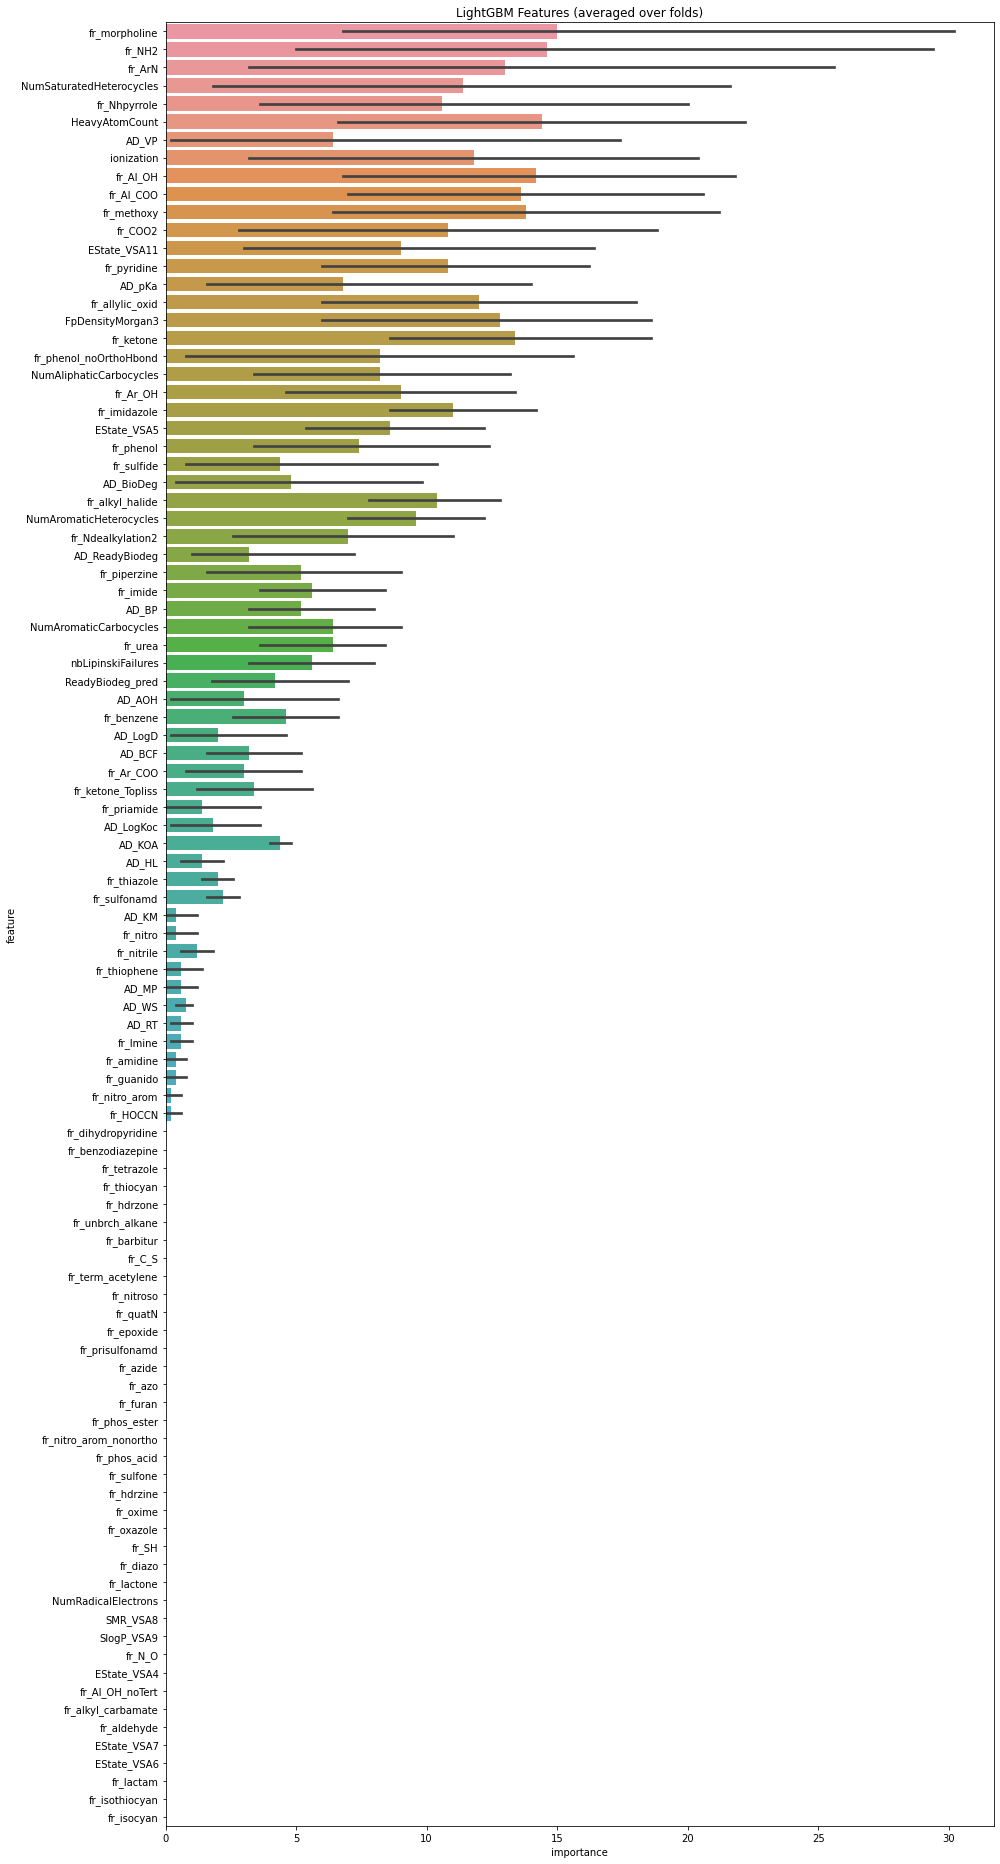

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[-100:].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [43]:
data[train_cols].corr()

,qed,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,...,LogBCF_pred,AD_BCF,BioDeg_LogHalfLife_pred,AD_BioDeg,ReadyBiodeg_pred,AD_ReadyBiodeg,LogKM_pred,AD_KM,LogKoc_pred,AD_LogKoc
qed,1.000000,-0.134815,-0.538324,-0.420199,-0.569401,0.011934,-0.106914,-0.066114,-0.111773,-0.092546,...,-0.017197,0.516187,-0.202935,0.142937,-0.100341,0.293126,0.031571,0.521287,-0.234508,0.390801
FractionCSP3,-0.134815,1.000000,0.040478,0.130394,0.071941,0.422066,0.273884,0.498077,-0.559540,-0.341420,...,-0.105633,-0.139734,0.236228,0.001817,0.216461,0.014105,0.064902,-0.161988,-0.001193,-0.155449
HeavyAtomCount,-0.538324,0.040478,1.000000,0.235806,0.673122,0.170677,0.382440,0.391444,0.440038,0.215585,...,0.199647,-0.538826,0.372546,-0.217474,-0.370385,-0.316049,0.339812,-0.518610,0.629869,-0.564496
NHOHCount,-0.420199,0.130394,0.235806,1.000000,0.611386,-0.014772,0.070964,0.038908,-0.094722,-0.041307,...,-0.341508,-0.313234,0.107470,-0.083357,0.177298,-0.253745,-0.387362,-0.393877,-0.177350,-0.096884
NOCount,-0.569401,0.071941,0.673122,0.611386,1.000000,-0.061756,0.372473,0.215677,0.037949,0.276679,...,-0.354730,-0.569980,0.077185,-0.238559,-0.059142,-0.441558,-0.058787,-0.468775,0.069351,-0.423888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AD_ReadyBiodeg,0.293126,0.014105,-0.316049,-0.253745,-0.441558,0.061574,-0.159156,-0.066605,-0.040234,-0.292539,...,0.173784,0.359560,-0.219339,0.133159,0.015131,1.000000,0.036731,0.202746,-0.121063,0.519192
LogKM_pred,0.031571,0.064902,0.339812,-0.387362,-0.058787,0.233140,0.177767,0.294229,0.191826,0.135557,...,0.435912,-0.032585,0.264887,-0.033429,-0.341713,0.036731,1.000000,-0.068908,0.451380,-0.241557
AD_KM,0.521287,-0.161988,-0.518610,-0.393877,-0.468775,-0.228022,-0.185277,-0.295184,-0.111710,-0.116102,...,0.069111,0.524366,-0.312628,0.192813,0.076799,0.202746,-0.068908,1.000000,-0.327501,0.437443
LogKoc_pred,-0.234508,-0.001193,0.629869,-0.177350,0.069351,0.367740,0.102538,0.342252,0.454093,0.078440,...,0.497770,-0.196574,0.444374,-0.123594,-0.392824,-0.121063,0.451380,-0.327501,1.000000,-0.420273
